# 題目
- 科系、職務與待遇：大數據時代下的社會學與勞動市場

- 挑戰：分析技術沒有跟上
- 機會：溝通能力
> 我會直接展示很多用 python 處理資料的邏輯，你們也可以想看看怎麼用SPSS實現，有沒有辦法做到&哪個快

探討學用之間的落差對於系所與學生來說都是相當重要的分析議題，系所可以藉此確認教學目標是否與勞動市場接軌，而對於學生來說則可以提早思考自己的職涯規劃。在這次的工作坊中我將帶著大家透過 Python 開發人力銀行的網路爬蟲程式，藉此截取人力銀行網站上 20 萬筆的職缺資料。並藉由這些職缺中的科系、職務、要求技能、待遇...等等資訊進行分析，檢視勞動市場是如何看待不同科系的學生與勞動狀況。最後我將根據分析的結果給予相關建議，並說明在大數據時代下的社會學系有哪些機會與挑戰。

# 載入套件
- miniconda 下載

In [1]:
import pandas as pd
import numpy as np
import os
import re
import requests
import prince
import json
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:80% !important; }</style>"))
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

# 載入資料

- specialty:擅長工具
- skill:工作技能

## 讀取資料

In [2]:
path = '../../DataScience/WebCrawler/HumanResource_104/data/JobDetail.pkl'
df = pd.read_pickle(path)
print(df.shape)
df.head(3)

(200729, 34)


,jobName,appearDate,custName,hrName,email,phone,acceptRole,workExp,edu,major,...,workType,addressRegion,addressDetail,manageResp,businessTrip,workPeriod,vacationPolicy,startWorkingDay,hireType,industry
0,作業員,2020/09/15,總信食品有限公司,胡慧敏小姐,,,"[{'code': 1, 'description': '上班族'}, {'code': 2...",不拘,高中、專科、大學,[],...,[],台中市南屯區,工業區二十二路17號,不需負擔管理責任,無需出差外派,日班/晚班，需輪班,週休二日,不限,0,食品什貨批發業
1,汐止分院護理人員(內外科病房.加護病房.門診.安寧病房.護理之家),2020/09/15,國泰醫療財團法人國泰綜合醫院,李宿華小姐,sue@cgh.org.tw,,"[{'code': 1, 'description': '上班族'}, {'code': 6...",不拘,專科、大學,[護理助產相關],...,[],新北市汐止區,建成路59巷2號,不需負擔管理責任,無需出差外派,日班/晚班，需輪班,依公司規定,不限,0,醫院
2,印刷見習技師,2020/09/18,康揚特殊美術印刷股份有限公司,邱先生,ford521213@yahoo.com.tw,,"[{'code': 1, 'description': '上班族'}, {'code': 2...",不拘,高中、專科、大學,[],...,[],台北市南港區,南港路三段50巷9號5樓,不需負擔管理責任,無需出差外派,日班/晚班，08:00~17:30，需輪班,週休二日,一週內,0,印刷業


In [10]:
# df.head(1000).to_excel('../../DataScience/WebCrawler/HumanResource_104/data/JobDetail.xlsx',index=False)

## 保留需要的欄位
- jobName 職缺名稱
- custName 公司名稱
- workExp 工作經歷
- edu 教育程度
- major 科系
- specialty 擅長工具
- skill 工作技能
- jobDetail 工作內容
- jobCategory 職務類別
- salary 待遇
- salaryMin 最低待遇
- salaryMax 最高待遇
- salaryType 待遇類型
- addressRegion 縣市區域
- addressDetail 地址
- industry 產業

In [12]:
df = df.loc[:,['jobName','custName','workExp','edu','major', 'specialty','skill','jobDetail', 'jobCategory',
              'salary','salaryMin','salaryMax','salaryType','addressRegion','addressDetail','industry']]
df.head(3)

,jobName,custName,workExp,edu,major,specialty,skill,jobDetail,jobCategory,salary,salaryMin,salaryMax,salaryType,addressRegion,addressDetail,industry
0,作業員,總信食品有限公司,不拘,高中、專科、大學,[],[],[],旺季需配合加班,"[{'code': '2010001002', 'description': '作業員／包裝...","月薪28,000~30,000元",28000,30000,50,台中市南屯區,工業區二十二路17號,食品什貨批發業
1,汐止分院護理人員(內外科病房.加護病房.門診.安寧病房.護理之家),國泰醫療財團法人國泰綜合醫院,不拘,專科、大學,[護理助產相關],[],[],"病人護理照護。\r\n1.護理師月薪41,000~43,000元起\r\n2.包夜班費：4,...","[{'code': '2015001004', 'description': '護理師及護士...","月薪41,000~43,000元",41000,43000,50,新北市汐止區,建成路59巷2號,醫院
2,印刷見習技師,康揚特殊美術印刷股份有限公司,不拘,高中、專科、大學,[],[],[],1.在印刷機上安裝及調整印版。\r\n2.調整壓力。\r\n3.於印刷機著墨，裝上紙張，並根...,"[{'code': '2010001012', 'description': '印前製作／印...","月薪26,000~36,000元",26000,36000,50,台北市南港區,南港路三段50巷9號5樓,印刷業


# 高薪的工作在哪裡？
> 練習根據不同的薪資型態統一整理成年薪

In [13]:
df['salary']

0         月薪28,000~30,000元
1         月薪41,000~43,000元
2         月薪26,000~36,000元
3         月薪23,800~40,000元
4                     待遇面議
                ...       
200724                待遇面議
200725    月薪27,000~80,000元
200726                待遇面議
200727    月薪35,000~50,000元
200728    月薪28,000~40,000元
Name: salary, Length: 200729, dtype: object

## 薪資有哪些類型?
- salaryType
 - 10: 面議
 - 20: 論件計酬
 - 30: 時薪
 - 40: 日薪
 - 50: 月薪
 - 60: 年薪

In [18]:
df.groupby('salaryType').head(1).sort_values('salaryType')

,jobName,custName,workExp,edu,major,specialty,skill,jobDetail,jobCategory,salary,salaryMin,salaryMax,salaryType,addressRegion,addressDetail,industry
4,美編設計(需具經驗),益盛多媒體印刷有限公司,3年以上,不拘,[],"[{'code': '12001003001', 'description': 'A+'},...",[],美編設計人員:需熟Adobe InDesign、Illustrator、Photoshop ...,"[{'code': '2013001005', 'description': '平面設計／美...",待遇面議,0,0,10,新北市中和區,立德街98巷123號2樓,印刷業
22,TOP1000大培訓專案行銷經理(承攬約),中國人壽保險(股)公司_至慶通訊處 (核可文號:中壽高屏業支網第20033101號),不拘,高中以上,[],[],[],歡歡迎主動積極、願意學習，想要開創屬於自己事業的菁英夥伴加入我們的行列。 \r\n ...,"[{'code': '2005003001', 'description': '國內業務主管...","論件計酬1~99,999元",1,99999,20,高雄市鼓山區,明誠四路156號7樓,人身保險業
382,才藝老師 (英文教學),芝麻街美語學校_新北市私立南蒂亞幼兒園,1年以上,專科以上,[],[],[],"1.可用英文上課,營造美語教學環境\r\n2.專長為舞蹈、圍棋、積木、珠心算、美術、電子琴（...","[{'code': '2016002016', 'description': '其他才藝類老...",時薪400~600元,400,600,30,新北市林口區,麗園路94號,學前教育事業
112,廚房助手,愛欣食品有限公司,不拘,高中以下、高中、專科、大學,[],[],[],煮飯.煮湯.油鍋幫忙\n學校送餐.有廚房經驗.\n要能搬重物.會開貨車\n有中餐丙級證照者....,"[{'code': '2006001002', 'description': '中餐廚師'}...","日薪1,500元",1500,1500,40,新北市淡水區,八勢一街1號,其他食品製造業
0,作業員,總信食品有限公司,不拘,高中、專科、大學,[],[],[],旺季需配合加班,"[{'code': '2010001002', 'description': '作業員／包裝...","月薪28,000~30,000元",28000,30000,50,台中市南屯區,工業區二十二路17號,食品什貨批發業
310,營造工程師(無經驗可培訓),建銘營造股份有限公司,不拘,大學、碩士,"[建築相關, 土木工程相關]",[],[],1.指揮並監督工人，以控制工程的施工進度與施工品質。\r\n2.材料進料時驗收\r\n3.編...,"[{'code': '2012002002', 'description': '工地監工／主...","年薪504,000~570,000元",504000,570000,60,新竹市,東區新竹科學園區,建築工程業


## 薪資統一成月薪
- 新鮮人沒有籌碼，通常都是拿最低薪資qq
- 面議(10): 直接是 4萬以上
- 年薪(60): 最低薪資除14計算來計算出月薪
- 月薪(50): 維持原月薪
- 日薪(40): 最低薪資*20個工作天
- 時薪(30): 最低薪資\*20個工作天\*8的工時
- 論件計酬(20): 當成0丟掉~

In [21]:
# 轉換成月薪
df['nsalaryMin'] = np.select(condlist = [df['salaryType'] == 10, # 面議, 
                                         df['salaryType'] == 60, # 年薪
                                         df['salaryType'] == 50, # 月薪
                                         df['salaryType'] == 40, # 日薪
                                         df['salaryType'] == 30], # 時薪
                             choicelist = [40000,
                                           df['salaryMin']/14,
                                           df['salaryMin'],
                                           df['salaryMin']*20,                                           
                                           df['salaryMin']*20*8])
df.groupby('salaryType').head(1).sort_values('salaryType')

,jobName,custName,workExp,edu,major,specialty,skill,jobDetail,jobCategory,salary,salaryMin,salaryMax,salaryType,addressRegion,addressDetail,industry,nsalaryMin
4,美編設計(需具經驗),益盛多媒體印刷有限公司,3年以上,不拘,[],"[{'code': '12001003001', 'description': 'A+'},...",[],美編設計人員:需熟Adobe InDesign、Illustrator、Photoshop ...,"[{'code': '2013001005', 'description': '平面設計／美...",待遇面議,0,0,10,新北市中和區,立德街98巷123號2樓,印刷業,40000.0
22,TOP1000大培訓專案行銷經理(承攬約),中國人壽保險(股)公司_至慶通訊處 (核可文號:中壽高屏業支網第20033101號),不拘,高中以上,[],[],[],歡歡迎主動積極、願意學習，想要開創屬於自己事業的菁英夥伴加入我們的行列。 \r\n ...,"[{'code': '2005003001', 'description': '國內業務主管...","論件計酬1~99,999元",1,99999,20,高雄市鼓山區,明誠四路156號7樓,人身保險業,0.0
382,才藝老師 (英文教學),芝麻街美語學校_新北市私立南蒂亞幼兒園,1年以上,專科以上,[],[],[],"1.可用英文上課,營造美語教學環境\r\n2.專長為舞蹈、圍棋、積木、珠心算、美術、電子琴（...","[{'code': '2016002016', 'description': '其他才藝類老...",時薪400~600元,400,600,30,新北市林口區,麗園路94號,學前教育事業,64000.0
112,廚房助手,愛欣食品有限公司,不拘,高中以下、高中、專科、大學,[],[],[],煮飯.煮湯.油鍋幫忙\n學校送餐.有廚房經驗.\n要能搬重物.會開貨車\n有中餐丙級證照者....,"[{'code': '2006001002', 'description': '中餐廚師'}...","日薪1,500元",1500,1500,40,新北市淡水區,八勢一街1號,其他食品製造業,30000.0
0,作業員,總信食品有限公司,不拘,高中、專科、大學,[],[],[],旺季需配合加班,"[{'code': '2010001002', 'description': '作業員／包裝...","月薪28,000~30,000元",28000,30000,50,台中市南屯區,工業區二十二路17號,食品什貨批發業,28000.0
310,營造工程師(無經驗可培訓),建銘營造股份有限公司,不拘,大學、碩士,"[建築相關, 土木工程相關]",[],[],1.指揮並監督工人，以控制工程的施工進度與施工品質。\r\n2.材料進料時驗收\r\n3.編...,"[{'code': '2012002002', 'description': '工地監工／主...","年薪504,000~570,000元",504000,570000,60,新竹市,東區新竹科學園區,建築工程業,36000.0


In [24]:
df.sort_values('nsalaryMin', ascending=False).head(10)

,jobName,custName,workExp,edu,major,specialty,skill,jobDetail,jobCategory,salary,salaryMin,salaryMax,salaryType,addressRegion,addressDetail,industry,nsalaryMin
198309,TZ頂埔捷運站✤高薪4.5萬【固定班_週領6千】免費供餐✤免經驗➜轉職/待業都OK,艾肯國際開發有限公司,不拘,不拘,[],[],[],▃▃▃ 加Line好友詢問、預約面試 ▃▃▃\n★【週週領薪】➜芸小姐☎：097283788...,"[{'code': '2010001002', 'description': '作業員／包裝...","時薪40,000~52,000元",40000,52000,30,新北市土城區,✤【土城 中山路】➜頂埔捷運站走路10分鐘】✤,人力仲介代徵,6400000.0
150403,淡水機動保全員,泰翔保全股份有限公司,不拘,不拘,[],[],[],1.巡邏建築物與周遭環境，留意可疑線索，確保門窗安全。\r\n2.回應警報器並且調查引起警鈴...,"[{'code': '2017002001', 'description': '保全人員／警...","時薪34,000元",34000,34000,30,新北市淡水區,,保全樓管相關業,5440000.0
165595,數理輔導老師,台中市私立林子文理短期補習班,不拘,大學、碩士,[],[],[],協助輔導課業,"[{'code': '2016002011', 'description': '語文補習班老...","時薪30,000~45,000元",30000,45000,30,台中市西區,英才路455號,補習班,4800000.0
110402,管家,岳生生技股份有限公司,2年以上,高中以上,[],[],[],1.協助家務處理.\r\n2.外出接送或定點接送\r\n\r\n,"[{'code': '2018002013', 'description': '家事服務人員'}]","時薪30,000~35,000元",30000,35000,30,桃園市楊梅區,獅四路1號,其他食品製造業,4800000.0
111141,美容師 (漢神巨蛋),曼蒂造型設計,不拘,不拘,[],[],[],1.願接受本公司教育培訓。(研修期間薪資23800)\n2.有志學習專業一技之長者佳，對美容...,"[{'code': '2006003001', 'description': '美容工作者'...","時薪30,000~60,000元",30000,60000,30,高雄市左營區,博愛二路777號5樓,美髮業,4800000.0
62933,模組廠-模組設備常日班工程師(屏東廠),元晶太陽能科技股份有限公司,3年以上,專科、大學,"[工程學科類, 機械工程相關, 電機電子工程相關]",[],[],1.生產設備日常保養與故障排除\r\n2.機台破片率改善\r\n3.生產設備零、組件維修\r...,"[{'code': '2009002007', 'description': '半導體設備工...","時薪30,000~60,000元",30000,60000,30,屏東縣屏東市,大溪路335-12號,光電產業,4800000.0
2203,嬰幼兒托育人員/護理人員(可兼任),臺北市私立快樂托嬰中心,不拘,高中、專科、大學,"[學前教育相關, 兒童保育相關, 護理助產相關]",[],[],1. 0-3歲 嬰幼兒的安全與生活照顧\r\n2. 嬰幼兒教保活動帶領\r\n3. 親職溝通...,"[{'code': '2016002020', 'description': '教保員'},...","時薪29,000~39,000元",29000,39000,30,台北市內湖區,民權東路六段282號2樓,學前教育事業,4640000.0
44223,早班門市,大吉利生活百貨館_宏昇商行,不拘,不拘,[],[],[],1.負責介紹及銷售門市商品。\r\n2.提供顧客之接待與需求服務（如：電話諮詢、調貨、修改、...,"[{'code': '2005002004', 'description': '門市／店員／...","時薪28,000~35,000元",28000,35000,30,台北市中山區,錦州街386號1樓,百貨相關業,4480000.0
177086,清潔員晚班 (台北市大安區、信義區),一訂股份有限公司,不拘,不拘,[],[],[],1.工作內容：夜店/酒吧/餐酒，主要維護現場及廁所清潔，工作內容很簡單\n2.上班時間：排班...,"[{'code': '2018002012', 'description': '清潔工／資源...","時薪27,000~35,000元",27000,35000,30,台北市信義區,或大安區,家事服務業,4320000.0
97489,(社區教育)社區烘培坊-烘焙助手,甘樂文創志業股份有限公司,2年以上,大學、碩士,[],[],[],工作內容\r\n烘培人員工作內容\r\n1.烘培麵包及點心研發與製作\r\n2.店鋪服務、管...,"[{'code': '2006001005', 'description': '麵包師'},...","時薪26,400元",26400,26400,30,新北市三峽區,,廣告行銷公關業,4224000.0


> 結論: 乖乖找正常的工作比較合適~

# 哪些工作會想要找社會學系的學生?
- 因為是科系是複選題，所以需要處理一下資料!

## 展開科系

In [31]:
df_exp_by_major = df.explode('major')
df_exp_by_major

,jobName,custName,workExp,edu,major,specialty,skill,jobDetail,jobCategory,salary,salaryMin,salaryMax,salaryType,addressRegion,addressDetail,industry,nsalaryMin
0,作業員,總信食品有限公司,不拘,高中、專科、大學,NaN,[],[],旺季需配合加班,"[{'code': '2010001002', 'description': '作業員／包裝...","月薪28,000~30,000元",28000,30000,50,台中市南屯區,工業區二十二路17號,食品什貨批發業,28000.0
1,汐止分院護理人員(內外科病房.加護病房.門診.安寧病房.護理之家),國泰醫療財團法人國泰綜合醫院,不拘,專科、大學,護理助產相關,[],[],"病人護理照護。\r\n1.護理師月薪41,000~43,000元起\r\n2.包夜班費：4,...","[{'code': '2015001004', 'description': '護理師及護士...","月薪41,000~43,000元",41000,43000,50,新北市汐止區,建成路59巷2號,醫院,41000.0
2,印刷見習技師,康揚特殊美術印刷股份有限公司,不拘,高中、專科、大學,NaN,[],[],1.在印刷機上安裝及調整印版。\r\n2.調整壓力。\r\n3.於印刷機著墨，裝上紙張，並根...,"[{'code': '2010001012', 'description': '印前製作／印...","月薪26,000~36,000元",26000,36000,50,台北市南港區,南港路三段50巷9號5樓,印刷業,26000.0
3,證券營業員(南科分公司),國票綜合證券股份有限公司,不拘,專科以上,NaN,[],[],1.對證券現貨、期貨及新金融商品投資具興趣。 \r\n2.自認可吃苦耐勞、勇於負責者。 \r...,"[{'code': '2003002005', 'description': '金融營業員'...","月薪23,800~40,000元",23800,40000,50,台南市新市區,',證券及期貨業,23800.0
4,美編設計(需具經驗),益盛多媒體印刷有限公司,3年以上,不拘,NaN,"[{'code': '12001003001', 'description': 'A+'},...",[],美編設計人員:需熟Adobe InDesign、Illustrator、Photoshop ...,"[{'code': '2013001005', 'description': '平面設計／美...",待遇面議,0,0,10,新北市中和區,立德街98巷123號2樓,印刷業,40000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200726,準公幼貝萊登幼兒園-高年級安親班老師,嘉義市私立貝萊登幼兒園,1年以上,大學以上,學前教育相關,[],[],1.協助孩童完成當天功課，並注意寫字的工整。\r\n2.指導國小學生課業，如：幫孩童複習國語...,"[{'code': '2016002008', 'description': '安親班老師'}]",待遇面議,0,0,10,嘉義市,東區林森東路539號,學前教育事業,40000.0
200726,準公幼貝萊登幼兒園-高年級安親班老師,嘉義市私立貝萊登幼兒園,1年以上,大學以上,綜合教育相關,[],[],1.協助孩童完成當天功課，並注意寫字的工整。\r\n2.指導國小學生課業，如：幫孩童複習國語...,"[{'code': '2016002008', 'description': '安親班老師'}]",待遇面議,0,0,10,嘉義市,東區林森東路539號,學前教育事業,40000.0
200726,準公幼貝萊登幼兒園-高年級安親班老師,嘉義市私立貝萊登幼兒園,1年以上,大學以上,專業科目教育相關,[],[],1.協助孩童完成當天功課，並注意寫字的工整。\r\n2.指導國小學生課業，如：幫孩童複習國語...,"[{'code': '2016002008', 'description': '安親班老師'}]",待遇面議,0,0,10,嘉義市,東區林森東路539號,學前教育事業,40000.0
200727,Java程式開發工程師,藍科數位科技股份有限公司,1年以上,專科以上,NaN,"[{'code': '12001003025', 'description': 'Java'}]","[{'code': '11009002008', 'description': '軟體工程系...",Java Web應用程式維護、開發\r\n1. 具備 Java 基礎知識即可，我們很願意帶你...,"[{'code': '2007001004', 'description': '軟體設計工程...","月薪35,000~50,000元",35000,50000,50,台北市內湖區,行愛路151號2樓之2,電腦軟體服務業,35000.0


## 篩選社會學的職缺

In [42]:
soc_jobs = df_exp_by_major.loc[df_exp_by_major['major']=='社會學相關',:].copy()
soc_jobs.head(1)

,jobName,custName,workExp,edu,major,specialty,skill,jobDetail,jobCategory,salary,salaryMin,salaryMax,salaryType,addressRegion,addressDetail,industry,nsalaryMin
108,社工員(收出養服務中心),財團法人忠義社會福利事業基金會,不拘,大學以上,社會學相關,"[{'code': '12001008003', 'description': 'Excel...",[],1.個案工作：國內外收出養個案服務處遇、資源結合、宣導等。\r\n2.團體工作：收出養服務相...,"[{'code': '2016002018', 'description': '社工人員'}]","月薪31,000~36,000元",31000,36000,50,台北市文山區,,社會福利服務業,31000.0


## 斷詞

In [43]:
# 串接職缺名稱與工作描述
soc_jobs['jobDetail2'] = soc_jobs['jobName'] + soc_jobs['jobDetail']
soc_jobs.head(1)

,jobName,custName,workExp,edu,major,specialty,skill,jobDetail,jobCategory,salary,salaryMin,salaryMax,salaryType,addressRegion,addressDetail,industry,nsalaryMin,jobDetail2
108,社工員(收出養服務中心),財團法人忠義社會福利事業基金會,不拘,大學以上,社會學相關,"[{'code': '12001008003', 'description': 'Excel...",[],1.個案工作：國內外收出養個案服務處遇、資源結合、宣導等。\r\n2.團體工作：收出養服務相...,"[{'code': '2016002018', 'description': '社工人員'}]","月薪31,000~36,000元",31000,36000,50,台北市文山區,,社會福利服務業,31000.0,社工員(收出養服務中心)1.個案工作：國內外收出養個案服務處遇、資源結合、宣導等。\r\n2...


In [44]:
import jieba

In [45]:
jieba.lcut('為什麼工作這麼辛苦')

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\TL_Yu\AppData\Local\Temp\jieba.cache
Loading model cost 1.639 seconds.
Prefix dict has been built successfully.


['為', '什麼', '工作', '這麼', '辛苦']

In [47]:
jieba.add_word('為什麼')

In [48]:
jieba.lcut('為什麼工作這麼辛苦')

['為什麼', '工作', '這麼', '辛苦']

> 斷詞會需要依分析的場域來花一些時間建立專屬辭典

In [68]:
re.sub('[^\u4e00-\u9fa5]','',string='為什麼工作這麼辛苦2')

'為什麼工作這麼辛苦'

In [74]:
def sent2words(sent):
    sent = re.sub('[^\u4e00-\u9fa5]', '', sent) # 只保黎文本中的中文
    seg_list = jieba.lcut(sent) # 斷詞
    seg_list = [word for word in seg_list if len(word) >=2] # 保留大於兩個字的詞
    return seg_list

In [75]:
soc_jobs['jobDetail3'] = soc_jobs['jobDetail2'].apply(lambda x: sent2words(x))
soc_jobs

,jobName,custName,workExp,edu,major,specialty,skill,jobDetail,jobCategory,salary,salaryMin,salaryMax,salaryType,addressRegion,addressDetail,industry,nsalaryMin,jobDetail2,jobDetail3
108,社工員(收出養服務中心),財團法人忠義社會福利事業基金會,不拘,大學以上,社會學相關,"[{'code': '12001008003', 'description': 'Excel...",[],1.個案工作：國內外收出養個案服務處遇、資源結合、宣導等。\r\n2.團體工作：收出養服務相...,"[{'code': '2016002018', 'description': '社工人員'}]","月薪31,000~36,000元",31000,36000,50,台北市文山區,,社會福利服務業,31000.0,社工員(收出養服務中心)1.個案工作：國內外收出養個案服務處遇、資源結合、宣導等。\r\n2...,"[社工, 員收, 出養, 服務中心, 個案, 工作, 國內外, 收出, 個案, 服務處, 資..."
345,教保老師(恆愛發展中心),財團法人第一社會福利基金會,不拘,高中、專科、大學,社會學相關,[],[],訓練心智障礙學員的生活技能及職業陶冶,"[{'code': '2016002006', 'description': '特殊教育教師...","月薪28,000~34,000元",28000,34000,50,台北市信義區,松隆路36號6樓,社會福利服務業,28000.0,教保老師(恆愛發展中心)訓練心智障礙學員的生活技能及職業陶冶,"[教保, 老師, 恆愛, 發展, 中心, 訓練, 心智, 障礙, 學員, 生活, 技能, 職..."
871,社工,財團法人桃園市私立觀音愛心家園,不拘,大學、碩士,社會學相關,"[{'code': '12001008003', 'description': 'Excel...",[],從事個案管理、社資聯繫等。\r\n應徵者需具備社工相關科系畢業或修社工相關學分具有社工資格。,"[{'code': '2016002018', 'description': '社工人員'}...","月薪29,000~36,000元",29000,36000,50,桃園市觀音區,成功路一段250巷21號,社會福利服務業,29000.0,社工從事個案管理、社資聯繫等。\r\n應徵者需具備社工相關科系畢業或修社工相關學分具有社工資格。,"[社工, 從事, 個案, 管理社, 聯繫, 應徵者, 具備, 社工, 相關, 科系, 畢業,..."
1569,社工員,財團法人台灣基督教門諾會附設花蓮縣私立善牧中心,1年以上,大學,社會學相關,"[{'code': '12001008003', 'description': 'Excel...","[{'code': '11002002005', 'description': '專案規劃執...",1.方案執行與核銷。\r\n2.安置家園業務執行。\r\n3.行政業務。\r\n4.完成年度...,"[{'code': '2016002018', 'description': '社工人員'}]","月薪32,000~34,000元",32000,34000,50,花蓮縣花蓮市,中美路61號,社會福利服務業,32000.0,社工員1.方案執行與核銷。\r\n2.安置家園業務執行。\r\n3.行政業務。\r\n4.完...,"[社工, 方案, 執行, 核銷, 安置, 家園, 業務, 執行, 行政, 業務, 完成, 年..."
1818,志工管理專員(都監/信眾監院室),財團法人靈鷲山佛教基金會,1年以上,大學,社會學相關,"[{'code': '12001008003', 'description': 'Excel...",[],1.志工管理\r\n2.志工回山執勤服務協調\r\n3.志工組織,"[{'code': '2004001006', 'description': '活動企劃人員...","月薪28,000~37,000元",28000,37000,50,新北市永和區,保生路2號21樓(234),宗教組織,28000.0,志工管理專員(都監/信眾監院室)1.志工管理\r\n2.志工回山執勤服務協調\r\n3.志工組織,"[志工, 管理, 專員, 監信眾, 監院, 室志工, 管理, 志工, 回山, 執勤, 服務,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196856,居家服務督導員-雲林居家式長照機構,財團法人伊甸社會福利基金會,不拘,大學,社會學相關,[],[],1.居家服務個案訪視、派案。\n2.個案記錄撰寫與管理、相關系統資料鍵入與維護。\n3.居服...,"[{'code': '2015002012', 'description': '居家服務督導...","月薪32,000~36,000元",32000,36000,50,雲林縣北港鎮,新德路108號,社會福利服務業,32000.0,居家服務督導員-雲林居家式長照機構1.居家服務個案訪視、派案。\n2.個案記錄撰寫與管理、相...,"[居家, 服務, 督導員, 雲林, 居家, 機構, 居家, 服務, 個案, 訪視, 派案, ..."
197588,研究助理,高雄醫學大學_人力資源室,不拘,大學,社會學相關,[],[],1. 協助送審計畫 \n2. 研究收案（聯絡個案、問卷與認知功能評估、各單位聯繫） \n3....,"[{'code': '2016001013', 'description': '研究助理'}]","月薪32,450元",32450,32450,50,高雄市三民區,十全一路100號,大專校院教育事業,32450.0,研究助理1. 協助送審計畫 \n2. 研究收案（聯絡個案、問卷與認知功能評估、各單位聯繫） ...,"[研究, 助理, 協助, 審計, 研究, 收案, 聯絡, 個案, 問卷, 認知, 功能, 評..."
198539,代操作人員【駐廠代表】,英屬開曼群島商納諾股份有限公司台灣分公司,2年以上,高中,社會學相關,[],[],"1.監控廠內電儀設備運作,觀察機械的運作情形，偵測設備不足處或機械故障處，必要時須進行調整。...","[{'code': '2010001002', 'description': '作業員／包裝...","月薪30,000~40,000元",30000,40000,50,高雄市前鎮區,高雄市前鎮區南7路1號,其他相關製造業,30000.0,"代操作人員【駐廠代表】1.監控廠內電儀設備運作,觀察機械的運作情形，偵測設備不足處或機械故障...","[操作, 人員, 駐廠, 代表, 監控, 廠內, 電儀, 設備, 運作, 觀察, 機械, 運..."
199117,勝利加油站就業服務員,財團法人台北市勝利社會福利事業基金會,不拘,專科以上,社會學相關,[],[],身障者個案輔導、情緒諮商、工作訓練、開案晤談以及記錄,"[{'code': '2016002018', 'description': '社工人員'}...","月薪23,800~40,000元",23800,40000,50,台北市大安區,建國南路一段336號2樓,社會福利服務業,23800.0,勝利加油站就業服務員身障者個案輔導、情緒諮商、工作訓練、開案晤談以及記錄,"[勝利, 加油站, 就業, 服務員, 身障者, 個案, 輔導, 情緒, 諮商, 工作, 訓練..."


## 文字雲
- 這邊需要說明一下文字編碼的問題

In [76]:
from collections import Counter
z = soc_jobs['jobDetail3'][108]
Counter(z)

Counter({'社工': 1,
         '員收': 1,
         '出養': 1,
         '服務中心': 1,
         '個案': 2,
         '工作': 4,
         '國內外': 1,
         '收出': 3,
         '服務處': 1,
         '資源': 1,
         '結合': 1,
         '宣導': 1,
         '團體': 1,
         '服務': 2,
         '相關': 2,
         '方案': 1,
         '申請': 1,
         '擬定': 1,
         '執行': 1,
         '核銷': 1,
         '行政': 2,
         '成果': 1,
         '統計': 1})

In [77]:
nlist = []
for li in soc_jobs['jobDetail3']:
    nlist+=li
nlist

['社工',
 '員收',
 '出養',
 '服務中心',
 '個案',
 '工作',
 '國內外',
 '收出',
 '個案',
 '服務處',
 '資源',
 '結合',
 '宣導',
 '團體',
 '工作',
 '收出',
 '服務',
 '相關',
 '方案',
 '申請',
 '擬定',
 '執行',
 '核銷',
 '行政',
 '工作',
 '收出',
 '服務',
 '成果',
 '統計',
 '相關',
 '行政',
 '工作',
 '教保',
 '老師',
 '恆愛',
 '發展',
 '中心',
 '訓練',
 '心智',
 '障礙',
 '學員',
 '生活',
 '技能',
 '職業',
 '陶冶',
 '社工',
 '從事',
 '個案',
 '管理社',
 '聯繫',
 '應徵者',
 '具備',
 '社工',
 '相關',
 '科系',
 '畢業',
 '或修',
 '社工',
 '相關',
 '學分',
 '具有',
 '社工',
 '資格',
 '社工',
 '方案',
 '執行',
 '核銷',
 '安置',
 '家園',
 '業務',
 '執行',
 '行政',
 '業務',
 '完成',
 '年度',
 '社工',
 '專業',
 '研習',
 '訓練',
 '主管',
 '交辦',
 '事項',
 '方案',
 '招募',
 '年度',
 '定期',
 '合約',
 '社工',
 '職缺',
 '志工',
 '管理',
 '專員',
 '監信眾',
 '監院',
 '室志工',
 '管理',
 '志工',
 '回山',
 '執勤',
 '服務',
 '協調',
 '志工',
 '組織',
 '切膚',
 '之愛',
 '基金會',
 '居家',
 '服務',
 '督導員',
 '負責',
 '居家',
 '服務',
 '個案',
 '管理',
 '負責',
 '處理',
 '居服員',
 '異常',
 '作業',
 '意外事故',
 '處理',
 '負責',
 '居服員',
 '工作',
 '監督',
 '協助',
 '人員',
 '管理',
 '負責',
 '執行',
 '居家',
 '服務',
 '相關',
 '行政',
 '業務',
 '推展',
 '執行',
 '協助',
 '居家',
 '服務',
 '業務',

In [78]:
c = Counter(nlist)
c.most_common(20)

[('服務', 1166),
 ('工作', 622),
 ('個案', 589),
 ('相關', 565),
 ('管理', 496),
 ('照顧', 486),
 ('執行', 474),
 ('社工', 434),
 ('活動', 360),
 ('協助', 290),
 ('計畫', 282),
 ('業務', 270),
 ('交辦', 261),
 ('行政', 259),
 ('資源', 255),
 ('規劃', 255),
 ('事項', 252),
 ('社區', 245),
 ('辦理', 233),
 ('方案', 215)]

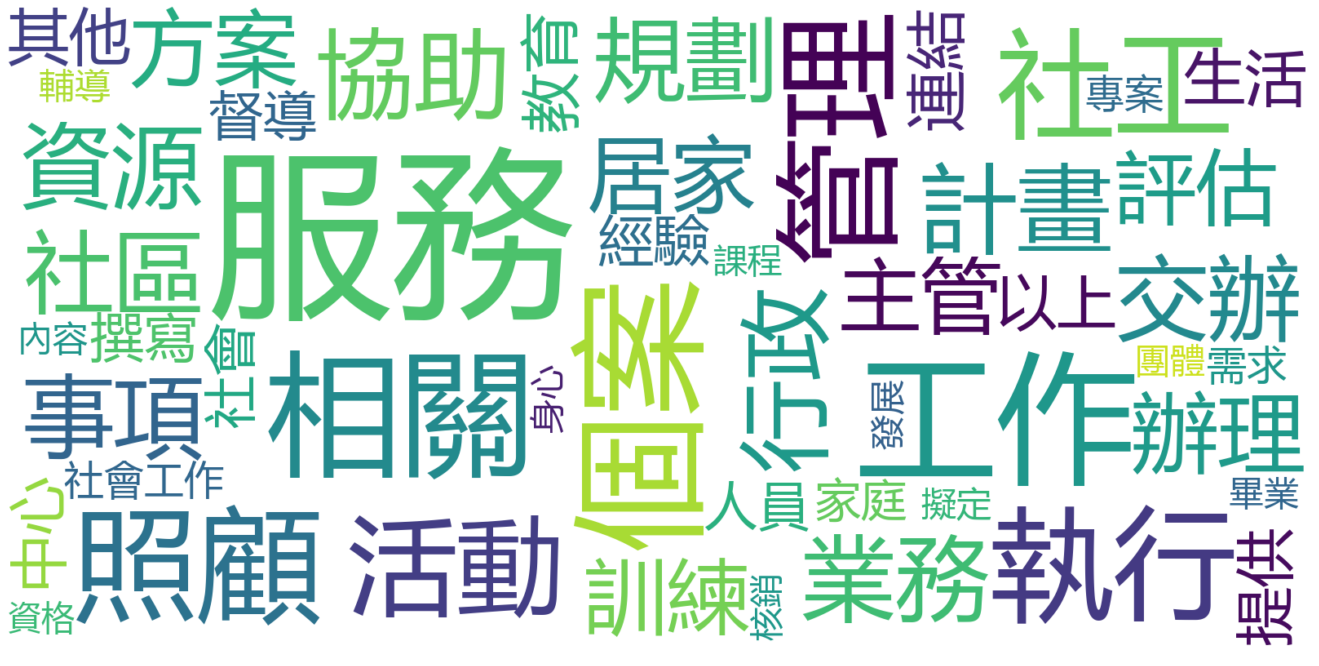

In [81]:
from wordcloud import WordCloud
plt.figure(figsize=(24, 12))
d = {}
# for k,v in zip(Fre_word['index'], Fre_word['Freq']):
for k,v in c.most_common(50):
    d[k] = int(v)
wordcloud = WordCloud(font_path='C:/Windows/Fonts/Microsoft YaHei/msyh.ttc',
                      width=1600,
                      height=800,
                      background_color="white").generate_from_frequencies(d)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
# plt.imshow(wordcloud, interpolation="bilinear")

> 分析: 勞動市場上對於社會學的期待目前還是跟社工當成相同的，要想辦法走出自己的路

# 市場上的勞動狀況怎麼樣？
> 用1.5倍 IQR的方式去除離群值
- 離群值的偵測方式
 - 9倍的平均絕對離差
 - 1.5倍IQR
 - 3倍的Z分數
 - 去除頭尾5%
- 或者你可以直接用中位數來看資料，在這裡選擇用中位數，因為我懶惰XD
- 去除後，計算各科系的中位數待遇，然後繪製bar圖

## 只要年薪、月薪、面議性質的工作

In [99]:
# 只要月薪、面議、與年薪的工作
df_exp_by_major = df_exp_by_major.loc[df_exp_by_major['salaryType'].apply(lambda x: x in [10, 50, 60]), :]
df_exp_by_major.head(1)

,jobName,custName,workExp,edu,major,specialty,skill,jobDetail,jobCategory,salary,salaryMin,salaryMax,salaryType,addressRegion,addressDetail,industry,nsalaryMin
0,作業員,總信食品有限公司,不拘,高中、專科、大學,NaN,[],[],旺季需配合加班,"[{'code': '2010001002', 'description': '作業員／包裝...","月薪28,000~30,000元",28000,30000,50,台中市南屯區,工業區二十二路17號,食品什貨批發業,28000.0


## 各科系的職缺數量

In [111]:
jobcnt_by_majors = df_exp_by_major.groupby('major').size().reset_index()
jobcnt_by_majors.columns = ['major', 'count']
jobcnt_by_majors = jobcnt_by_majors.sort_values('count', ascending=False)
jobcnt_by_majors

,major,count
148,電機電子工程相關,15477
127,資訊工程相關,9560
82,機械工程相關,9167
128,資訊管理相關,5691
54,工程學科類,5611
...,...,...
85,氣象學相關,6
36,哲學相關,6
129,軍事相關,4
34,區域研究相關,2


## 只保留前50大科系的職缺
- join的4種方式

In [112]:
df_exp_by_major

,jobName,custName,workExp,edu,major,specialty,skill,jobDetail,jobCategory,salary,salaryMin,salaryMax,salaryType,addressRegion,addressDetail,industry,nsalaryMin
0,作業員,總信食品有限公司,不拘,高中、專科、大學,NaN,[],[],旺季需配合加班,"[{'code': '2010001002', 'description': '作業員／包裝...","月薪28,000~30,000元",28000,30000,50,台中市南屯區,工業區二十二路17號,食品什貨批發業,28000.0
1,汐止分院護理人員(內外科病房.加護病房.門診.安寧病房.護理之家),國泰醫療財團法人國泰綜合醫院,不拘,專科、大學,護理助產相關,[],[],"病人護理照護。\r\n1.護理師月薪41,000~43,000元起\r\n2.包夜班費：4,...","[{'code': '2015001004', 'description': '護理師及護士...","月薪41,000~43,000元",41000,43000,50,新北市汐止區,建成路59巷2號,醫院,41000.0
2,印刷見習技師,康揚特殊美術印刷股份有限公司,不拘,高中、專科、大學,NaN,[],[],1.在印刷機上安裝及調整印版。\r\n2.調整壓力。\r\n3.於印刷機著墨，裝上紙張，並根...,"[{'code': '2010001012', 'description': '印前製作／印...","月薪26,000~36,000元",26000,36000,50,台北市南港區,南港路三段50巷9號5樓,印刷業,26000.0
3,證券營業員(南科分公司),國票綜合證券股份有限公司,不拘,專科以上,NaN,[],[],1.對證券現貨、期貨及新金融商品投資具興趣。 \r\n2.自認可吃苦耐勞、勇於負責者。 \r...,"[{'code': '2003002005', 'description': '金融營業員'...","月薪23,800~40,000元",23800,40000,50,台南市新市區,',證券及期貨業,23800.0
4,美編設計(需具經驗),益盛多媒體印刷有限公司,3年以上,不拘,NaN,"[{'code': '12001003001', 'description': 'A+'},...",[],美編設計人員:需熟Adobe InDesign、Illustrator、Photoshop ...,"[{'code': '2013001005', 'description': '平面設計／美...",待遇面議,0,0,10,新北市中和區,立德街98巷123號2樓,印刷業,40000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200726,準公幼貝萊登幼兒園-高年級安親班老師,嘉義市私立貝萊登幼兒園,1年以上,大學以上,學前教育相關,[],[],1.協助孩童完成當天功課，並注意寫字的工整。\r\n2.指導國小學生課業，如：幫孩童複習國語...,"[{'code': '2016002008', 'description': '安親班老師'}]",待遇面議,0,0,10,嘉義市,東區林森東路539號,學前教育事業,40000.0
200726,準公幼貝萊登幼兒園-高年級安親班老師,嘉義市私立貝萊登幼兒園,1年以上,大學以上,綜合教育相關,[],[],1.協助孩童完成當天功課，並注意寫字的工整。\r\n2.指導國小學生課業，如：幫孩童複習國語...,"[{'code': '2016002008', 'description': '安親班老師'}]",待遇面議,0,0,10,嘉義市,東區林森東路539號,學前教育事業,40000.0
200726,準公幼貝萊登幼兒園-高年級安親班老師,嘉義市私立貝萊登幼兒園,1年以上,大學以上,專業科目教育相關,[],[],1.協助孩童完成當天功課，並注意寫字的工整。\r\n2.指導國小學生課業，如：幫孩童複習國語...,"[{'code': '2016002008', 'description': '安親班老師'}]",待遇面議,0,0,10,嘉義市,東區林森東路539號,學前教育事業,40000.0
200727,Java程式開發工程師,藍科數位科技股份有限公司,1年以上,專科以上,NaN,"[{'code': '12001003025', 'description': 'Java'}]","[{'code': '11009002008', 'description': '軟體工程系...",Java Web應用程式維護、開發\r\n1. 具備 Java 基礎知識即可，我們很願意帶你...,"[{'code': '2007001004', 'description': '軟體設計工程...","月薪35,000~50,000元",35000,50000,50,台北市內湖區,行愛路151號2樓之2,電腦軟體服務業,35000.0


In [113]:
top50_major = pd.merge(left = df_exp_by_major,
                       right = jobcnt_by_majors.head(50),
                       on ='major',
                       how = 'inner')
top50_major

,jobName,custName,workExp,edu,major,specialty,skill,jobDetail,jobCategory,salary,salaryMin,salaryMax,salaryType,addressRegion,addressDetail,industry,nsalaryMin,count
0,汐止分院護理人員(內外科病房.加護病房.門診.安寧病房.護理之家),國泰醫療財團法人國泰綜合醫院,不拘,專科、大學,護理助產相關,[],[],"病人護理照護。\r\n1.護理師月薪41,000~43,000元起\r\n2.包夜班費：4,...","[{'code': '2015001004', 'description': '護理師及護士...","月薪41,000~43,000元",41000,43000,50,新北市汐止區,建成路59巷2號,醫院,41000.0,2791
1,汐止分院-專科護理師(內科.外科),國泰醫療財團法人國泰綜合醫院,不拘,大學,護理助產相關,[],[],"協助、參與病人醫療照護(值班另有優渥津貼)。\r\n1.護理師月薪42,000~50,000...","[{'code': '2015001004', 'description': '護理師及護士...","月薪42,000~50,000元",42000,50000,50,新北市汐止區,建成路59巷2號,醫院,42000.0,2791
2,護理之家護理人員,文雄醫院,1年以上,高中、專科、大學,護理助產相關,[],[],一般護理工作,"[{'code': '2015001004', 'description': '護理師及護士'}]","月薪34,000~36,000元",34000,36000,50,高雄市三民區,察哈爾二街132號(807),醫院,34000.0,2791
3,健檢中心護理師/護士,中心診所醫療財團法人中心綜合醫院,不拘,高中、專科、大學、碩士,護理助產相關,[],[],1.負責執行健檢中心健康檢查服務、抽血、心電圖、量血壓、骨質密度檢查等。\r\n2.提供健康...,"[{'code': '2015001004', 'description': '護理師及護士...","月薪32,000~36,000元",32000,36000,50,台北市大安區,忠孝東路四段77號10樓,醫院,32000.0,2791
4,總院 護理部 內科病房護理人員,國泰醫療財團法人國泰綜合醫院,1年以上,專科、大學,護理助產相關,[],[],內科病房臨床護理工作,"[{'code': '2015001004', 'description': '護理師及護士...","月薪39,000~43,000元",39000,43000,50,台北市大安區,仁愛路四段280號,醫院,39000.0,2791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116264,(Senior) Clinical Research Associate (Taipei/H...,IQVIA_艾昆緯股份有限公司,2年以上,大學以上,醫學系相關,"[{'code': '12001001032', 'description': 'Windo...",[],Join us on our exciting journey!\r\n\r\nIQVIA™...,"[{'code': '2008003002', 'description': '醫藥研發人員...",待遇面議,0,0,10,台北市松山區,民生東路三段138號7樓,生化科技研發業,40000.0,1179
116265,驗光/銷售人員,巴黎三城眼鏡股份有限公司,不拘,專科以上,醫學系相關,[],[],驗光師/驗光生\r\n1.執行非醫療、手術、或藥物之視力檢查及眼鏡處方或矯治。\r\n2.配...,"[{'code': '2005002004', 'description': '門市／店員／...","月薪36,000~70,000元",36000,70000,50,台北市士林區,忠誠路2段55號 大葉高島屋百貨4F,百貨相關業,36000.0,1179
116266,急診科主治醫師,天主教仁慈醫療財團法人仁慈醫院,不拘,大學以上,醫學系相關,[],[],1.執行急診醫療業務。\r\n2.上班時數:6-15班/月(可依彈性需求)。\r\n3.平日...,"[{'code': '2015001001', 'description': '醫師'}]",待遇面議,0,0,10,新竹縣湖口鄉,忠孝路29號,醫院,40000.0,1179
116267,急診醫學科主治醫師,天主教靈醫會醫療財團法人羅東聖母醫院,3年以上,大學以上,醫學系相關,[],[],工作內容：1.執行急診醫療臨床業務\r\n 2.科內相關行政業務\r\n備...,"[{'code': '2015001001', 'description': '醫師'}]",待遇面議,0,0,10,宜蘭縣羅東鎮,中正南路160號(265),醫院,40000.0,1179


## boxplot

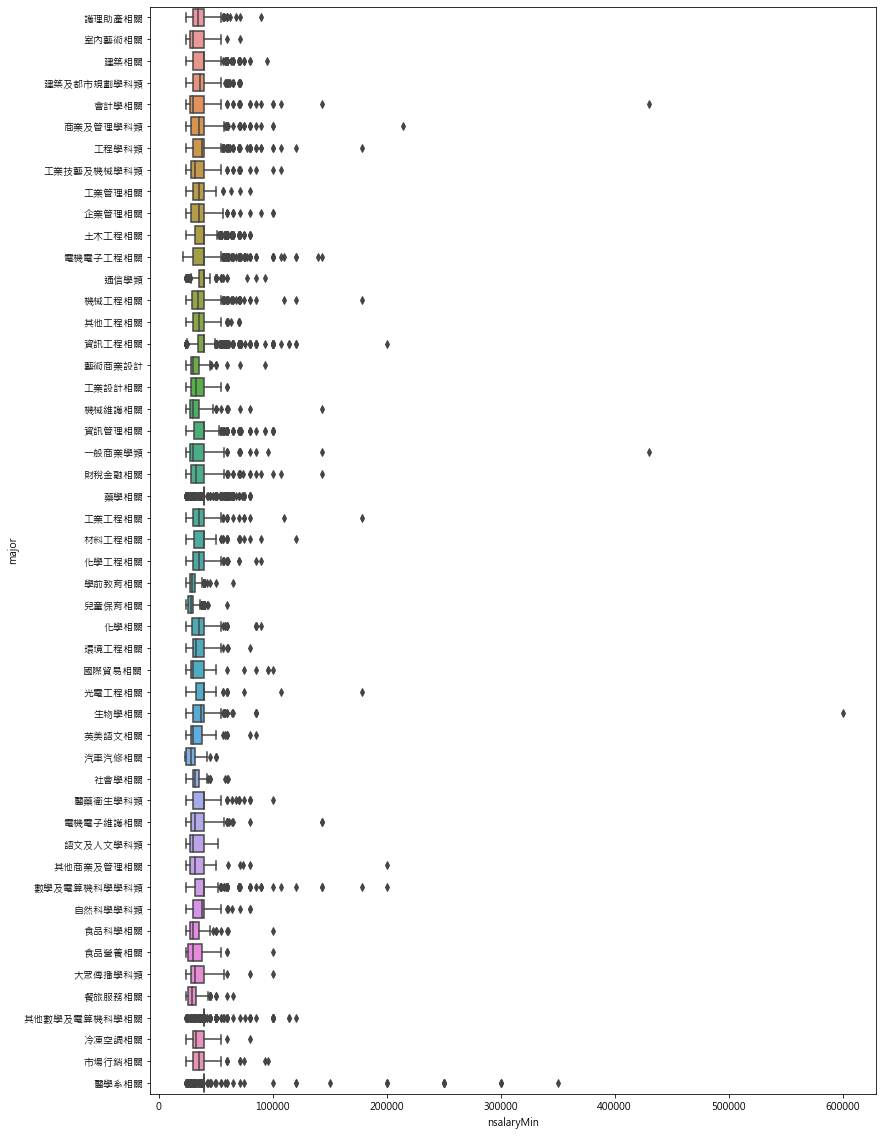

In [123]:
plt.figure(figsize=(13,20))
sns.boxplot(x='nsalaryMin', y='major', data=top50_major, orient='h',)

- 月薪大於10萬的資料不多，把它們丟掉後重新繪圖
- 如果覺得不清楚的還可以再把上限降低~

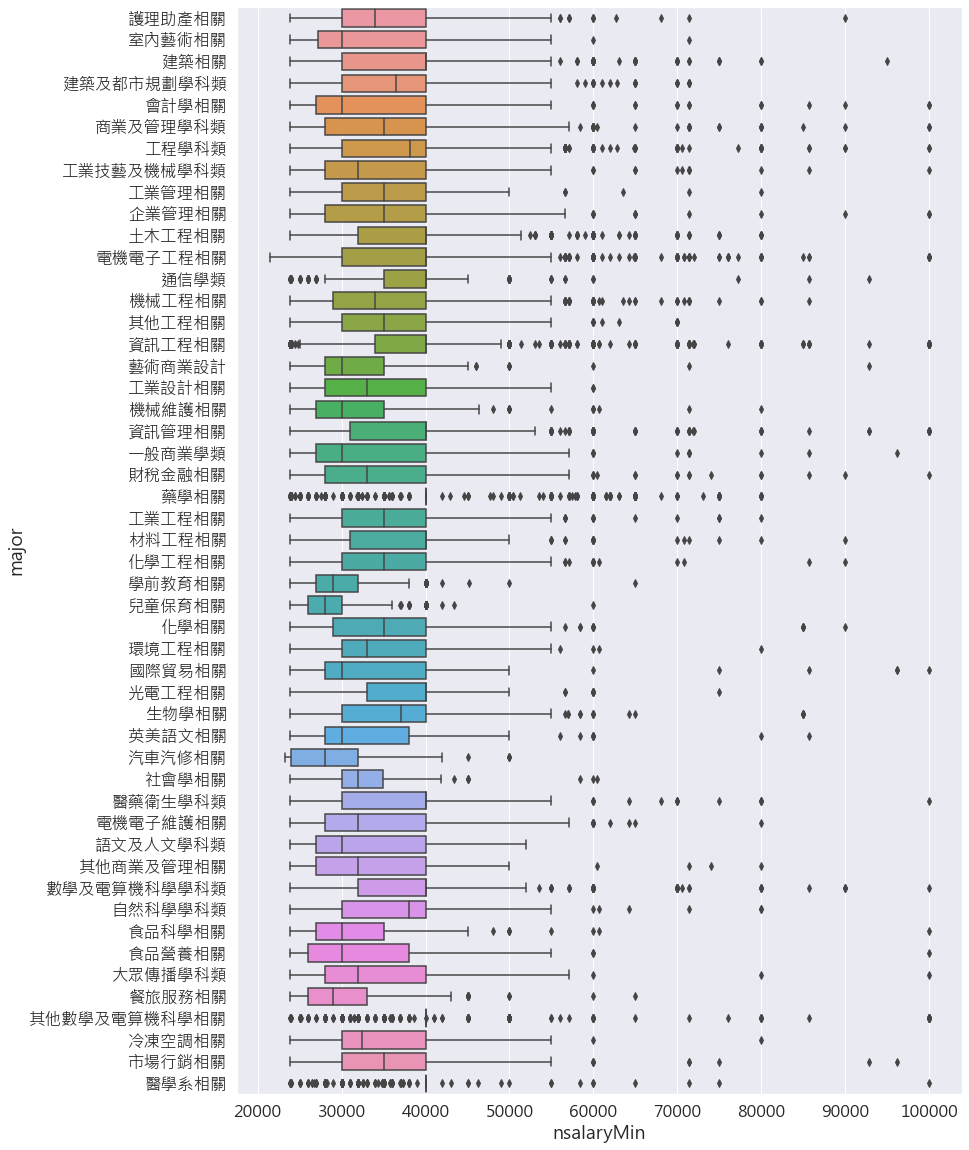

In [131]:
sns.set(font_scale=1.5,font='Microsoft JhengHei')
plt.figure(figsize=(13,20))
sns.boxplot(x='nsalaryMin',
            y='major',
            data=top50_major.loc[top50_major['nsalaryMin']<=100000,:],
            orient='h')
# plt.rc('xtick', labelsize=8)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=8) 

# 資料科學的職缺要會哪些技能/工具

In [134]:
df.head(1)

,jobName,custName,workExp,edu,major,specialty,skill,jobDetail,jobCategory,salary,salaryMin,salaryMax,salaryType,addressRegion,addressDetail,industry,nsalaryMin
0,作業員,總信食品有限公司,不拘,高中、專科、大學,[],[],[],旺季需配合加班,"[{'code': '2010001002', 'description': '作業員／包裝...","月薪28,000~30,000元",28000,30000,50,台中市南屯區,工業區二十二路17號,食品什貨批發業,28000.0


In [139]:
df.loc[np.select(condlist = [df['jobName'].apply(lambda x: bool(re.search('資料科學|數據分析|資料分析', x))),
                             df['jobDetail'].apply(lambda x: bool(re.search('資料科學|數據分析|資料分析', x)))],
          choicelist = [True,True],
          default=False),:].head(20)

,jobName,custName,workExp,edu,major,specialty,skill,jobDetail,jobCategory,salary,salaryMin,salaryMax,salaryType,addressRegion,addressDetail,industry,nsalaryMin
48,工地測量人員(無經驗可),政皓工程有限公司,不拘,不拘,[],[],[],1.大地工程安全監測、監測儀器安裝量測、數據分析、自動化監測系統。\n2.儀器送檢並追蹤進度...,"[{'code': '2012003005', 'description': '量測／儀校人...","月薪30,000元以上",30000,9999999,50,新北市板橋區,龍泉街55巷28弄1號1樓,建築工程業,30000.0
307,網路系統工程師 (一年以上contractor)_台北/桃園,台灣恩悌悌系統股份有限公司,1年以上,專科,[資訊工程相關],"[{'code': '12001007014', 'description': 'Check...",[],1. 1.\t網路設備及數據線路狀態檢視\r\n2. 網路架構資料製作及更新\r\n3. 設...,"[{'code': '2007002005', 'description': '網路管理工程...","月薪37,000元以上",37000,9999999,50,台北市松山區,南京東路五段188號14樓,電腦系統整合服務業,37000.0
414,國外業務助理/國外業務 (儲備幹部),泰瑋電子有限公司,2年以上,專科、大學,[商業及管理學科類],[],[],1.負責國外業務接洽，完成銷售業務之行政後勤工作，訂單之處理及客戶端之溝通事宜\r\n2. ...,"[{'code': '2005003013', 'description': '業務助理'}...","月薪35,000元以上",35000,9999999,50,新北市中和區,"中山路二段359巷4,6,8號4樓",其他電子零組件相關業,35000.0
458,FA助理工程師,銘鈺精密工業股份有限公司,1年以上,高中、專科、大學、碩士,[],"[{'code': '12001008003', 'description': 'Excel...",[],1.具工程識圖能力/GD&T 計算能力/基本量具使用\n2.Mitutoyo cmm/Nik...,"[{'code': '2009003002', 'description': '品管／品保工...","月薪30,000~40,000元",30000,40000,50,桃園市觀音區,觀音工業區國瑞路二號(328),其他電子零組件相關業,30000.0
538,"數位廣告業務助理 (酷比廣告, 宇匯知識科技)",宇匯知識科技股份有限公司,不拘,專科、大學、碩士,[],"[{'code': '12001008003', 'description': 'Excel...","[{'code': '11001005001', 'description': '文件收發與...",宇匯知識科技是一家專門做AI廣告投遞技術的公司，我們在台灣有十多年大數據廣告投遞的資料與經驗...,"[{'code': '2005003013', 'description': '業務助理'}...","月薪26,000~30,000元",26000,30000,50,台北市松山區,復興北路143號8樓,電腦軟體服務業,26000.0
811,散熱設計工程師(士林),Inventec_英業達股份有限公司,不拘,大學、碩士,"[機械工程相關, 航太工程相關, 工程學科類]",[],[],1. Notebook/AIO/Thin Client/Mini-DT 系統之散熱模擬\n2...,"[{'code': '2008001028', 'description': '熱傳工程師'...",待遇面議,0,0,10,台北市士林區,後港街66號,電腦及其週邊設備製造業,40000.0
968,企劃 Planner,凱絡媒體服務股份有限公司,不拘,專科、大學、碩士,[],"[{'code': '12001008003', 'description': 'Excel...",[],1. 客戶關係維繫\n2. 媒體企劃及客戶服務\n3. 撰寫媒體企劃、媒體月報及提案\n4....,"[{'code': '2004001005', 'description': '行銷企劃人員...","月薪28,000~32,000元",28000,32000,50,台北市信義區,松仁路100號8F,廣告行銷公關業,28000.0
2213,倉管主管 (W/H MGR),泰詠電子股份有限公司,3年以上,大學、碩士,[],"[{'code': '12001008003', 'description': 'Excel...",[],促進團隊管理效能及執行物料排程，持續優化原物料及產品之收發、儲存及盤點機制確保料帳合一且供應...,"[{'code': '2011001002', 'description': '資材主管'}...","月薪50,000~75,000元",50000,75000,50,新竹市,香山區牛埔東路480號,消費性電子產品製造業,50000.0
2510,營業儲備幹部(台南中山店),新光三越百貨股份有限公司,不拘,大學、碩士,[],[],[],1.對流行事物及百貨市場具高度興趣及敏銳度\n2.思考創新，對商品內容具創意，可開發新廠商及...,"[{'code': '2005002001', 'description': '店長／賣場管...","月薪30,000~39,000元",30000,39000,50,台南市中西區,中山路162號,百貨相關業,30000.0
2627,PHP網站工程師/SEO工程師,摩根國際購物股份有限公司,2年以上,專科以上,"[資訊管理相關, 資訊工程相關, 電機電子維護相關]","[{'code': '12001001007', 'description': 'Linux...",[],1.以PHP界接大型Restful Web Service (例如海外購物網站)\r\n2....,"[{'code': '2007001006', 'description': 'Intern...","月薪34,000~45,000元",34000,45000,50,新竹縣竹北市,復興三路二段168號6樓之1,網際網路相關業,34000.0


In [142]:
df.loc[df['jobName'].apply(lambda x: bool(re.search('資料|分析|數據', x))),:]

,jobName,custName,workExp,edu,major,specialty,skill,jobDetail,jobCategory,salary,salaryMin,salaryMax,salaryType,addressRegion,addressDetail,industry,nsalaryMin
84,研發檢驗分析部組長,南光化學製藥股份有限公司,5年以上,碩士以上,"[藥學相關, 化學相關, 生物學相關]",[],[],"1. 熟悉化學藥分析方法開發與確效作業。\r\n2. 熟悉實驗室儀器原理，具HPLC, HP...","[{'code': '2008003002', 'description': '醫藥研發人員...",待遇面議,0,0,10,台南市新化區,中山路1001號,化學原料製造業,40000.0
192,化學分析人員,界霖科技股份有限公司,1年以上,專科、大學、碩士,[化學工程相關],"[{'code': '12001008003', 'description': 'Excel...",[],1.藥液濃度分析及報表製作。\n2.固定晚班。,"[{'code': '2008002005', 'description': '實驗化驗人員'}]","月薪27,000~32,000元",27000,32000,50,高雄市楠梓區,楠梓加工區新經一路12號,半導體製造業,27000.0
227,雲端應用伺服器振動衝擊與結構分析專員/主管 - J0185,廣達電腦股份有限公司,3年以上,碩士以上,"[機械工程相關, 河海或船舶工程相關, 航太工程相關]",[],[],"1. 伺服器耐振動衝擊設計, 分析與實驗.\r\n2. 伺服器結構強度設計與分析.\r\n3...","[{'code': '2008001006', 'description': '機械工程師'...",待遇面議,0,0,10,桃園市龜山區,文化二路211號,電腦及其週邊設備製造業,40000.0
315,系統分析師(商用軟體部),中菲電腦股份有限公司,3年以上,專科以上,"[資訊工程相關, 其他數學及電算機科學相關]",[],[],主要產品為整合微軟管理產品加值之資訊系統；\r\n對於金融產業有經驗或興趣尤佳;\r\n本工...,"[{'code': '2007001007', 'description': '電腦系統分析...","月薪40,000~60,000元",40000,60000,50,台北市內湖區,行愛路151號,電腦軟體服務業,40000.0
350,有機分析員,CME奇美關係企業_佳美檢驗科技股份有限公司,1年以上,大學、碩士,"[化學相關, 環境工程相關]","[{'code': '12001008003', 'description': 'Excel...",[],1.環境及食品檢測分析\r\n2.空氣、水質、土壤、廢棄物及食品等分析\r\n3.有操作過G...,"[{'code': '2008002005', 'description': '實驗化驗人員...","月薪24,000~39,000元",24000,39000,50,台中市西屯區,工業區32路5號,檢測技術服務,24000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200400,SA系統分析師,汎宇電商股份有限公司,2年以上,專科、大學、碩士,[],[],[],1. 系統分析1年以上工作經驗。\r\n2. 熟悉專案作業流程，含客戶需求訪談、分析文件製作...,"[{'code': '2007001007', 'description': '電腦系統分析...",待遇面議,0,0,10,台北市南港區,南港路三段50巷7號4樓,網際網路相關業,40000.0
200432,無機化學分析師(台北),SGS _ 台灣檢驗科技股份有限公司,不拘,大學、碩士,"[化學相關, 化學工程相關]",[],[],重金屬、鹵素、離子等無機檢驗分析，實驗方法開發,"[{'code': '2008002005', 'description': '實驗化驗人員...","月薪28,000~50,000元",28000,50000,50,新北市五股區,五工路134號,檢測技術服務,28000.0
200496,進口資料輸入OP,聯締國際有限公司,不拘,高中以上,[],"[{'code': '12001008003', 'description': 'Excel...",[],1.分類、審核進口文件EXCEL資料，並轉入系統建檔。\r\n2.負責處理資料補件作業。\r...,"[{'code': '2002001006', 'description': '資料輸入人員...","月薪25,000~35,000元",25000,35000,50,桃園市大園區,航翔路107號2樓W2031室,綜合商品批發代理業,25000.0
200554,系統分析師,明門實業股份有限公司,6年以上,大學、碩士,"[資訊工程相關, 資訊管理相關]",[],[],1. 執行專案系統分析、規劃、功能驗證及系統測試、上線等工作。 \n2. 內部客戶需求訪談、...,"[{'code': '2007001007', 'description': '電腦系統分析...",待遇面議,0,0,10,台北市內湖區,瑞光路433號10F,其他運輸工具及零件製造修配業,40000.0


In [136]:
df['skill']

0                                                        []
1                                                        []
2                                                        []
3                                                        []
4                                                        []
                                ...                        
200724                                                   []
200725    [{'code': '11009010001', 'description': '文書處理軟...
200726                                                   []
200727    [{'code': '11009002008', 'description': '軟體工程系...
200728                                                   []
Name: skill, Length: 195794, dtype: object

### 擅長工具

In [71]:
special = []
for index, specialties in zip(df['index'], df['specialty']):
    if len(specialties) >= 1:
        for specialty in specialties:
            special.append([index, specialty['description']])
special = pd.DataFrame(special, columns = ['index', 'specialty'])
special.head()

,index,specialty
0,4,A+
1,4,HTML
2,4,jQuery
3,4,Adobe InDesign
4,4,Flash


In [72]:
special['specialty'].value_counts().reset_index().head(50)

,index,specialty
0,Excel,37729
1,Word,36115
2,PowerPoint,26493
3,Outlook,14750
4,AutoCAD,8503
5,Adobe Photoshop,5393
6,中文打字20~50,4289
7,Illustrator,3933
8,中文打字50~75,2520
9,英文打字20~50,2378


### 工作技能

In [73]:
skill_sep = []
for index, skills in zip(df['index'], df['skill']):
    if len(skills) >= 1:
        for skill in skills:
            skill_sep.append([index, skill['description']])
skill_sep = pd.DataFrame(skill_sep, columns = ['index', 'skill'])
skill_sep.head()

,index,skill
0,6,麵包食品製作
1,11,行銷製作物規劃與執行
2,15,商品進貨入庫作業
3,15,倉庫貨物標示╱置放╱盤點
4,15,倉管流程訂定與管理


In [74]:
skill_sep['skill'].value_counts().reset_index().head(50)

,index,skill
0,產品介紹及解說銷售,3176
1,業務或通路開發,2607
2,行政事務處理,2200
3,軟體程式設計,2067
4,櫃檯門市接待與需求服務,2022
5,業績目標分配與績效達成,1962
6,客戶資料更新維護,1909
7,客訴案件處理,1869
8,提案與簡報技巧,1695
9,文書處理╱排版能力,1625


# 分析
- 市場上哪些工作會想要找社會學系的學生? 這些工作的工作內容是什麼?
  - 撈取要求社會學的職缺名稱/工作內容，做簡單的文本分析
- 不同科系職缺的就業狀況有哪些差異?
  - 不同科系、待遇、技能的 MCA 分析
- 這幾年大數據很熱門，也有很多公司在做數位轉型，社會學系的學生在這個方面有哪些挑戰與機會?
  - 根據 2 的結果進一步分析
> 碎碎唸：一般公司不會買SPSS，即時是SAS也在被淘汰中，學會用開源的分析軟體分析、建模能讓你降低找工作的門檻

- 社會上對於社會學系畢業的學生的期待還是比較接近社工，因此工作內容大多是社會工作、照顧個案、執行計劃、撰寫計劃等等的內容
- 但如果是社工的話，社會學相對沒有優勢，因為社工還需要取得相關的證照、實習的經驗
> 給系上的提醒：社會學的職涯路線是什麼? 還需要系主任&老師們多討論

## 不同科系職缺的就業狀況有哪些差異?
- 待遇、職務、技能、科系的MCA
- 職業的類別太多了，也許可以專心比較前50大科系，每個科系取前3的產業做分析，繪製成2維或3維的分析圖
- 這邊要做標準化，每種技能要除上各科系的職缺總數

### 科系
- 前50大的科系

In [38]:
majorcate.head()

,index,major
0,1,護理助產相關
1,5,護理助產相關
2,8,室內藝術相關
3,8,建築相關
4,8,建築及都市規劃學科類


In [39]:
# 前 50大科系
top50_majors = majorcate['major'].value_counts().reset_index().head(50)
top50_majors.columns = ['major', 'cnt']
top50_majors

,major,cnt
0,電機電子工程相關,15463
1,資訊工程相關,9551
2,機械工程相關,9161
3,資訊管理相關,5686
4,工程學科類,5604
5,商業及管理學科類,4753
6,土木工程相關,3586
7,電機電子維護相關,3580
8,會計學相關,3538
9,建築相關,3492


In [40]:
# 前50大科系的職缺
top50_jobdesc = pd.merge(left = majorcate,
                           right = top50_majors.loc[:,'major'],
                           how = 'inner',
                           on = 'major')
top50_jobdesc

,index,major
0,1,護理助產相關
1,5,護理助產相關
2,101,護理助產相關
3,139,護理助產相關
4,158,護理助產相關
...,...,...
116141,199768,醫學系相關
116142,199830,醫學系相關
116143,200245,醫學系相關
116144,200478,醫學系相關


### 薪資

In [41]:
sal_major = pd.merge(left = top50_jobdesc,
                     right = df.loc[:,['index','nsalaryMin']],
                     how='left',
                     on = 'index')
sal_major = sal_major.groupby(['major','nsalaryMin']).size().reset_index()
sal_major.columns = ['major','nsalaryMin', 'cnt']
sal_major = sal_major.pivot_table(values='cnt',columns='nsalaryMin',index='major')
sal_major

nsalaryMin,25-30k,25k-,30-35k,35-40k,40k+
major,,,,,
一般商業學類,973,224,635,226,906
企業管理相關,554,96,504,257,935
光電工程相關,119,14,220,130,792
兒童保育相關,334,45,148,37,40
其他商業及管理相關,204,55,155,65,239
其他工程相關,167,17,242,96,459
其他數學及電算機科學相關,41,4,108,70,687
冷凍空調相關,191,29,327,115,315
化學工程相關,442,45,620,298,944


In [42]:
import prince
ca = prince.CA(
     n_components=2,
     n_iter=100,
     copy=True,
     check_input=True,
     engine='auto',
     random_state=42
 )
X = sal_major
X.columns.rename('Salary', inplace=True)
X.index.rename('Major', inplace=True)
ca = ca.fit(X)

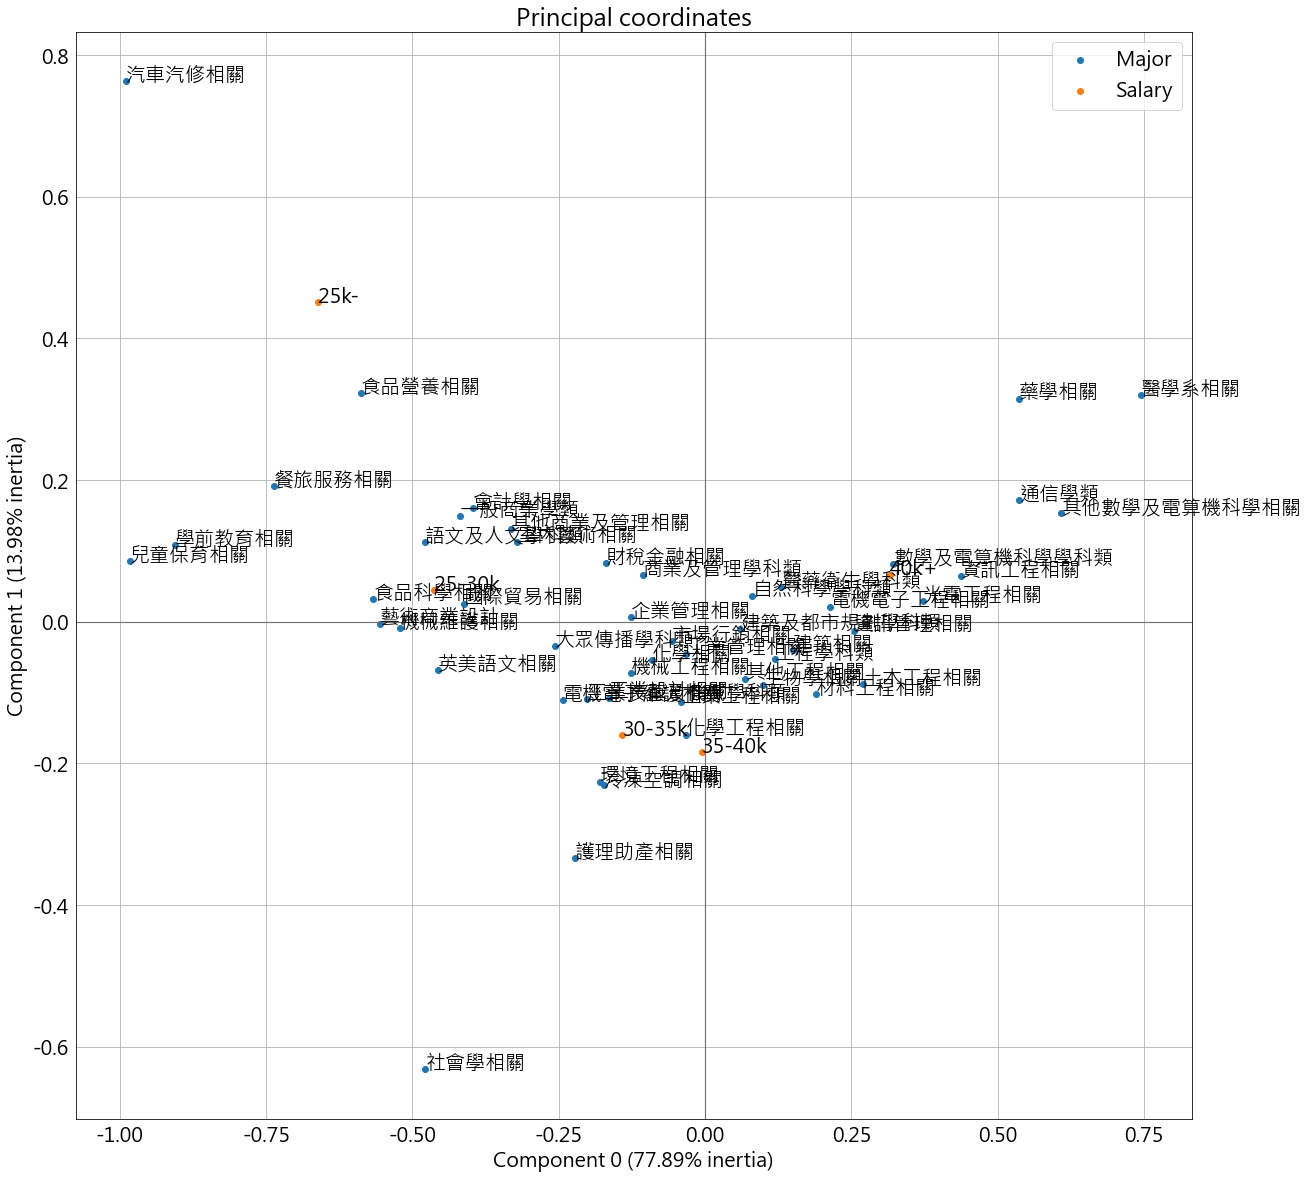

In [48]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

ax = ca.plot_coordinates(
     X=X,
     ax=None,
     figsize=(20, 20),
     x_component=0,
     y_component=1,
     show_row_labels=True,
     show_col_labels=True )
ax

### 職務
職務的項目較多較雜，為了簡化分析，在這裡將前50大科系各自取前3的職務

In [49]:
jobcate_major = pd.merge(left = top50_jobdesc,
                         right = jobcate.loc[:,['index','desc']],
                         how='left',
                         on = 'index')
jobcate_major = jobcate_major.groupby(['major','desc']).size().reset_index()
jobcate_major.columns = ['major','desc', 'cnt']
jobcate_major = jobcate_major.sort_values(['major','cnt'],ascending=False)#.groupby('major').head(3)
jobcate_major

,major,desc,cnt
8261,餐旅服務相關,餐飲服務生,170
8258,餐旅服務相關,飯店工作人員,168
8259,餐旅服務相關,飯店或餐廳主管,126
8260,餐旅服務相關,餐廚助手,117
8165,餐旅服務相關,中餐廚師,115
...,...,...,...
185,一般商業學類,運輸交通專業人員,1
198,一般商業學類,電機工程技術員,1
199,一般商業學類,電機裝修工,1
204,一般商業學類,韌體設計工程師,1


In [50]:
top3_eachmajor = jobcate_major.groupby('major')['desc'].head(3).reset_index().drop_duplicates('desc')
top3_eachmajor#.loc[:,['desc']]

,index,desc
0,8261,餐飲服務生
1,8258,飯店工作人員
2,8259,飯店或餐廳主管
3,8065,品管／檢驗人員
4,8157,食品研發人員
...,...,...
133,907,機電技師／工程師
140,600,托育人員
142,441,光電工程師
143,440,光學工程師


In [51]:
jobcate_major

,major,desc,cnt
8261,餐旅服務相關,餐飲服務生,170
8258,餐旅服務相關,飯店工作人員,168
8259,餐旅服務相關,飯店或餐廳主管,126
8260,餐旅服務相關,餐廚助手,117
8165,餐旅服務相關,中餐廚師,115
...,...,...,...
185,一般商業學類,運輸交通專業人員,1
198,一般商業學類,電機工程技術員,1
199,一般商業學類,電機裝修工,1
204,一般商業學類,韌體設計工程師,1


In [52]:
jobcate_major = pd.merge(left = jobcate_major,
                         right = top3_eachmajor.loc[:,['desc']],
                         how='inner',
                         on='desc')
jobcate_major = jobcate_major.pivot_table(values='cnt',columns='desc',index='major', fill_value=0)
jobcate_major

desc,ISO／品保人員,Internet程式設計師,主辦會計,人力資源人員,光學工程師,光電工程師,其他機械操作員,其他汽車／機車技術維修人員,其他醫療人員,助教,...,醫藥研發人員,電信／通訊系統工程師,電子工程師,電機工程技術員,電機技師／工程師,韌體設計工程師,食品研發人員,飯店工作人員,飯店或餐廳主管,餐飲服務生
major,,,,,,,,,,,,,,,,,,,,,
一般商業學類,10,3,316,77,0,0,0,0,2,2,...,0,0,0,1,0,1,0,18,11,7
企業管理相關,14,5,64,216,0,0,0,3,3,0,...,0,1,1,1,0,0,0,9,19,10
光電工程相關,11,0,0,0,171,252,5,0,0,0,...,0,34,271,32,73,63,0,0,0,0
兒童保育相關,0,0,0,0,0,0,0,0,3,68,...,0,0,0,0,0,0,0,1,0,2
其他商業及管理相關,2,1,47,27,0,0,0,0,1,0,...,1,0,0,1,0,0,0,1,4,1
其他工程相關,20,9,0,0,7,9,19,1,0,0,...,0,7,79,39,68,30,0,3,0,0
其他數學及電算機科學相關,2,206,0,0,2,1,0,0,0,0,...,0,27,30,0,6,96,0,0,0,0
冷凍空調相關,0,0,0,0,1,0,15,3,0,0,...,0,2,4,172,162,0,0,11,1,0
化學工程相關,96,0,0,0,13,34,98,0,0,0,...,65,1,23,21,28,0,23,0,0,0


In [53]:
import prince
ca = prince.CA(
     n_components=2,
     n_iter=100,
     copy=True,
     check_input=True,
     engine='auto',
     random_state=42
 )
X = jobcate_major
X.columns.rename('jobcate', inplace=True)
X.index.rename('Major', inplace=True)
ca = ca.fit(X)

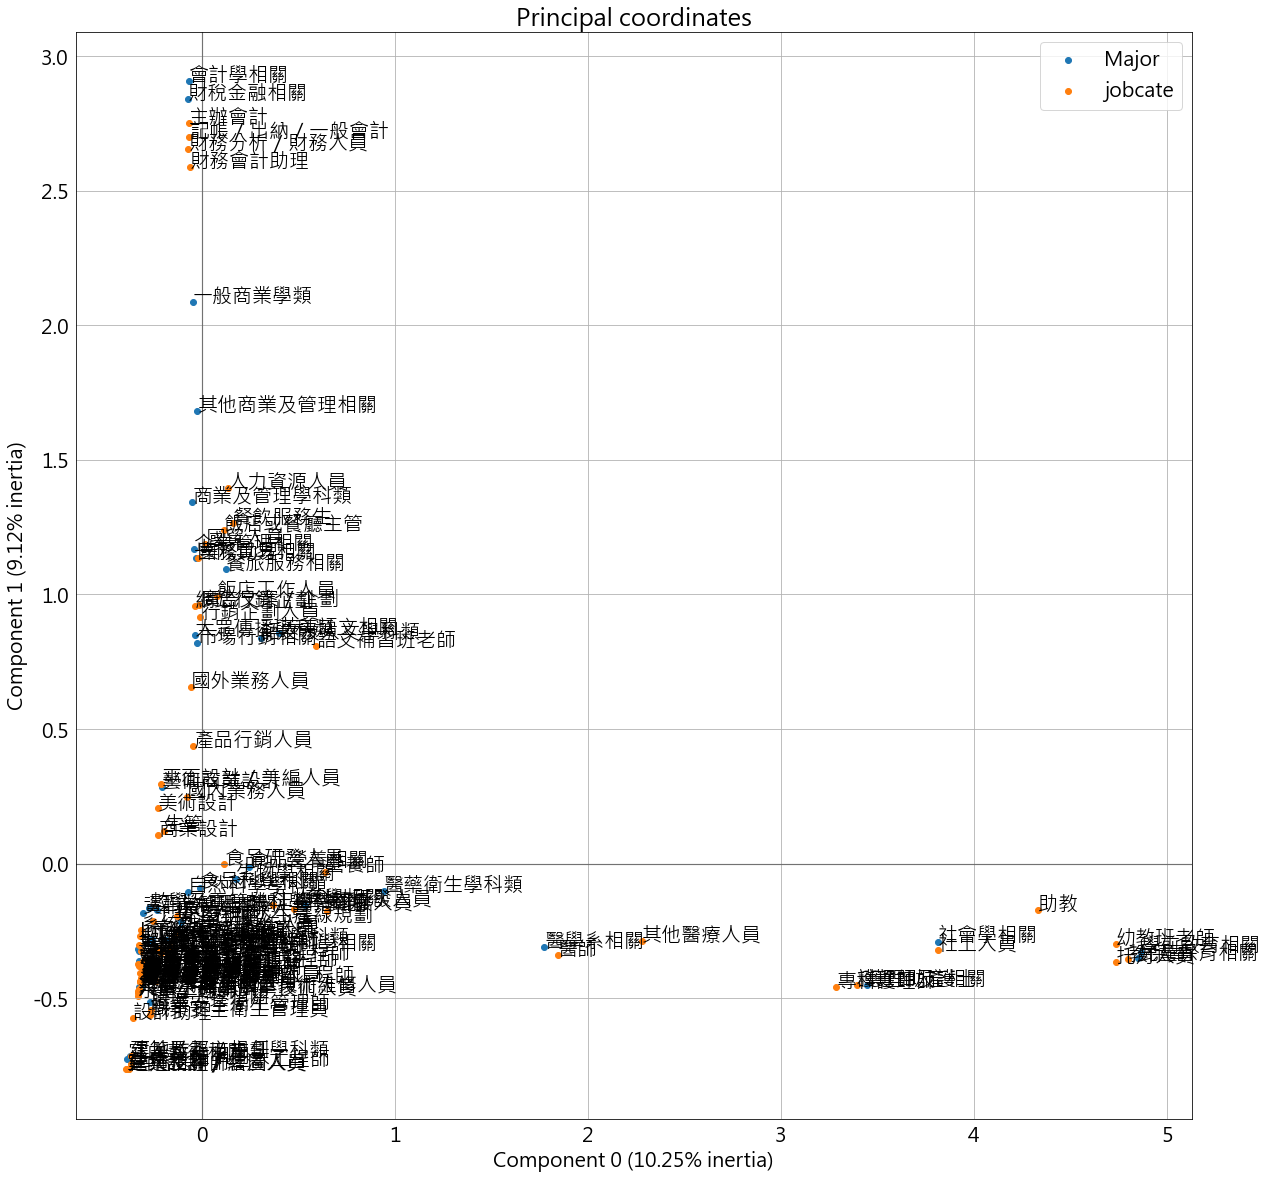

In [54]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

ax = ca.plot_coordinates(
     X=X,
     ax=None,
     figsize=(20, 20),
     x_component=0,
     y_component=1,
     show_row_labels=True,
     show_col_labels=True )
ax

### 技能
技能的項目較多較雜，為了簡化分析，在這裡將前50大科系各自取前3的技能

In [55]:
skill_sep

,index,skill
0,6,麵包食品製作
1,11,行銷製作物規劃與執行
2,15,商品進貨入庫作業
3,15,倉庫貨物標示╱置放╱盤點
4,15,倉管流程訂定與管理
...,...,...
159384,200725,文書處理軟體操作
159385,200727,軟體工程系統開發
159386,200727,功能測試(function test)
159387,200727,軟體程式設計


In [56]:
skill_major = pd.merge(left = top50_jobdesc,
                       right = skill_sep.loc[:,['index','skill']],
                       how='left',
                       on = 'index')
skill_major = skill_major.groupby(['major','skill']).size().reset_index()
skill_major.columns = ['major','skill', 'cnt']
skill_major = skill_major.sort_values(['major','cnt'],ascending=False)#.groupby('major').head(3)
skill_major

,major,skill,cnt
13805,餐旅服務相關,食材貯存管理,125
13804,餐旅服務相關,食材成本控制,115
13790,餐旅服務相關,門市餐飲管理,108
13807,餐旅服務相關,食物製前準備,97
13701,餐旅服務相關,廚房設備維護管理,96
...,...,...,...
377,一般商業學類,電子化企業資源規劃執行,1
378,一般商業學類,電子設備操作簡修,1
380,一般商業學類,電機設備操作,1
390,一般商業學類,食品衛生保健,1


In [57]:
top3skill_eachmajor = skill_major.groupby('major')['skill'].head(3).reset_index().drop_duplicates('skill')
top3skill_eachmajor#.loc[:,['desc']]

,index,skill
0,13805,食材貯存管理
1,13804,食材成本控制
2,13790,門市餐飲管理
3,13626,食品加工相關知識
4,13630,食品衛生保健
...,...,...
131,1987,網路程式設計
134,1702,水電相關圖表繪製
142,847,PCB Layout軟體操作
143,853,PCB電路板設計


In [58]:
skill_major = pd.merge(left = skill_major,
                         right = top3skill_eachmajor.loc[:,['skill']],
                         how='inner',
                         on='skill')
skill_major = skill_major.pivot_table(values='cnt',columns='skill',index='major', fill_value=0)
skill_major

skill,PCB Layout軟體操作,PCB電路板設計,了解皮膚構造與特性,作業系統基本操作,具備人力資源相關知識,冷凍空調工程之規劃施工,化學分析能力,化學檢測儀器操作,品牌行銷管理,國外業務開發,...,電子電路設計,電機設備保養修護,電腦繪圖軟體操作,電腦輔助設計軟體操作,預防保護之護理措施,食品加工相關知識,食品研發技術,食品衛生保健,食材成本控制,食材貯存管理
major,,,,,,,,,,,,,,,,,,,,,
一般商業學類,0,0,0,12,36,0,0,0,41,37,...,0,0,7,0,0,0,0,1,3,1
企業管理相關,0,0,2,13,100,0,0,0,82,26,...,0,0,3,0,0,0,0,0,5,4
光電工程相關,28,22,0,3,0,1,3,1,1,1,...,35,6,1,4,0,0,0,0,0,0
兒童保育相關,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
其他商業及管理相關,0,0,2,1,13,0,0,0,20,13,...,0,0,2,0,0,0,0,1,2,0
其他工程相關,8,7,0,6,0,5,1,1,0,3,...,7,8,1,14,0,0,0,0,0,0
其他數學及電算機科學相關,4,3,0,57,0,0,0,0,0,0,...,2,1,1,1,0,0,0,0,0,0
冷凍空調相關,2,1,0,0,0,36,0,0,1,1,...,1,28,0,8,0,0,0,0,0,0
化學工程相關,0,1,1,2,0,0,103,77,4,3,...,0,3,1,4,1,1,2,1,0,0


In [59]:
import prince
ca = prince.CA(
     n_components=2,
     n_iter=100,
     copy=True,
     check_input=True,
     engine='auto',
     random_state=42
 )
X = skill_major
X.columns.rename('skill', inplace=True)
X.index.rename('Major', inplace=True)
ca = ca.fit(X)

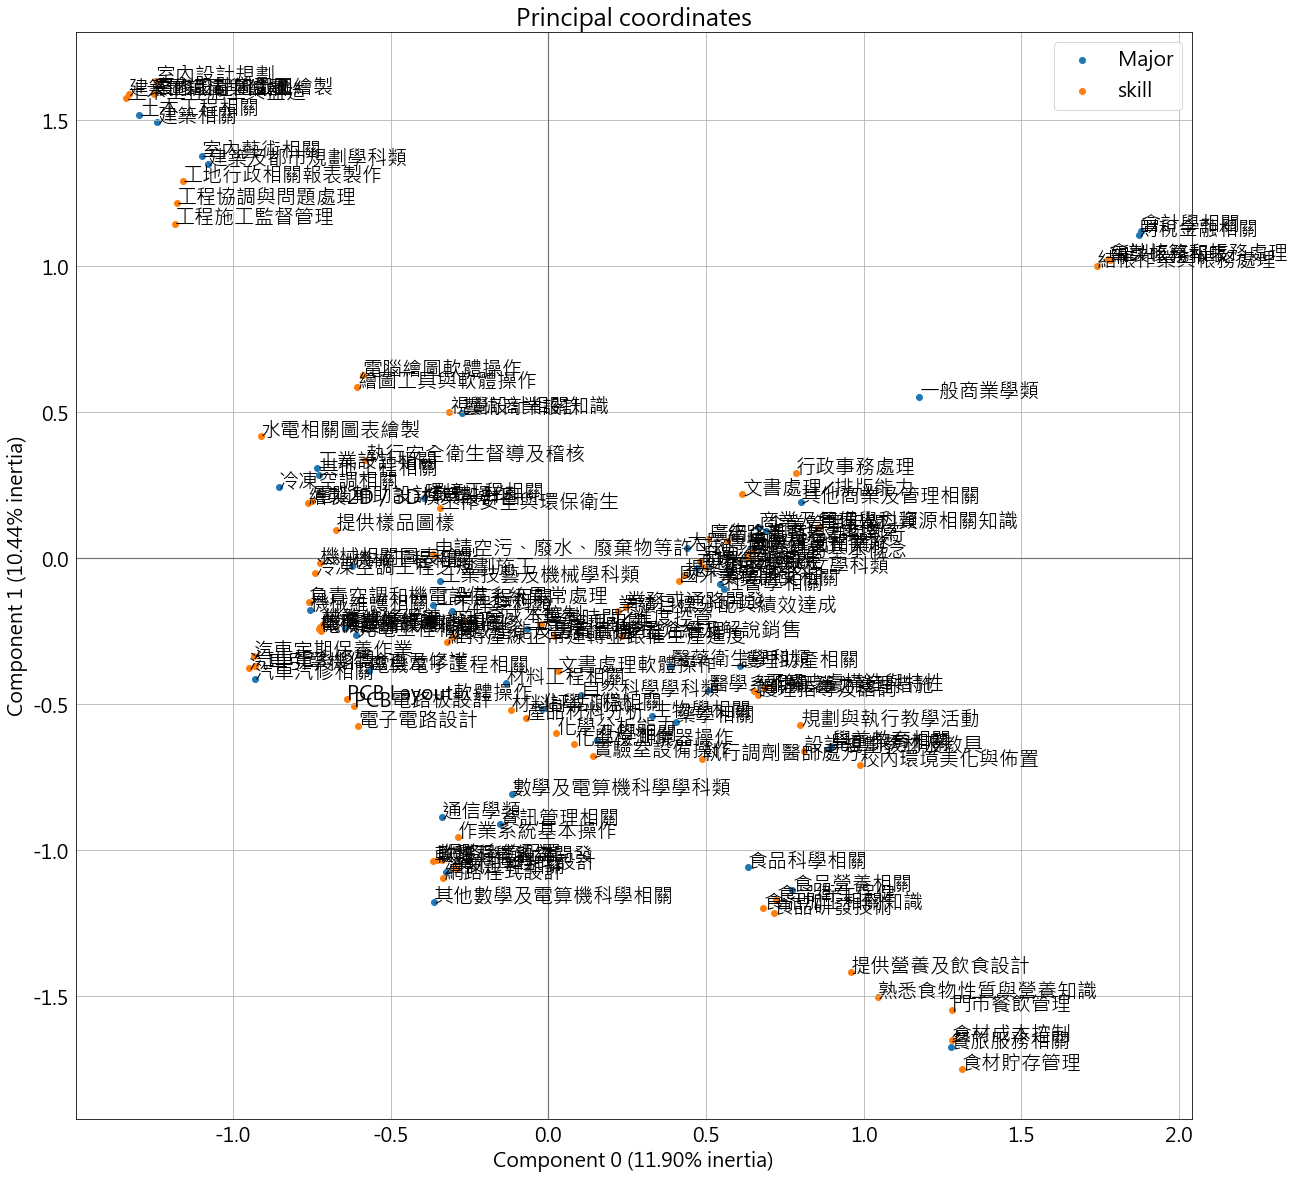

In [60]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

ax = ca.plot_coordinates(
     X=X,
     ax=None,
     figsize=(20, 20),
     x_component=0,
     y_component=1,
     show_row_labels=True,
     show_col_labels=True )
ax

### 工具
> excel、word、ppt是基本能力，如果你只會這些的話其實沒有什麼特色

In [62]:
special

,index,specialty
0,4,A+
1,4,HTML
2,4,jQuery
3,4,Adobe InDesign
4,4,Flash
...,...,...
222394,200722,Word
222395,200723,Excel
222396,200723,Outlook
222397,200723,Word


In [63]:
special_major = pd.merge(left = top50_jobdesc,
                         right = special.loc[:,['index','specialty']],
                         how='left',
                         on = 'index')
special_major = special_major.groupby(['major','specialty']).size().reset_index()
special_major.columns = ['major','specialty', 'cnt']
special_major = special_major.sort_values(['major','cnt'],ascending=False)#.groupby('major').head(3)
special_major

,major,specialty,cnt
6147,餐旅服務相關,Excel,202
6167,餐旅服務相關,Word,197
6157,餐旅服務相關,PowerPoint,135
6156,餐旅服務相關,Outlook,97
6169,餐旅服務相關,中文打字20~50,21
...,...,...,...
102,一般商業學類,Windows NT,1
112,一般商業學類,jQuery,1
114,一般商業學類,中文打字125~150,1
115,一般商業學類,中文打字150以上,1


In [64]:
top3specialty_eachmajor = special_major.groupby('major')['specialty'].head(5).reset_index().drop_duplicates('specialty')
top3specialty_eachmajor#.loc[:,['desc']]

,index,specialty
0,6147,Excel
1,6167,Word
2,6157,PowerPoint
3,6156,Outlook
4,6169,中文打字20~50
9,6105,HACCP
18,5864,AutoCAD
35,5238,C
36,5240,C++
39,5288,Linux


In [65]:
special_major = pd.merge(left = special_major,
                         right = top3specialty_eachmajor.loc[:,['specialty']],
                         how='inner',
                         on='specialty')
special_major = special_major.pivot_table(values='cnt',columns='specialty',index='major', fill_value=0)
special_major

specialty,Adobe Photoshop,AutoCAD,C,C#,C++,Excel,HACCP,HTML,Illustrator,Java,...,Python,Sketch up,SolidWorks,Windows 10,Windows 2000,Windows 7,Word,中文打字20~50,中文打字50~75,鼎新
major,,,,,,,,,,,,,,,,,,,,,
一般商業學類,60,24,1,2,1,1647,0,6,40,0,...,4,3,5,87,30,93,1529,193,148,172
企業管理相關,86,22,0,9,0,1206,0,6,55,6,...,0,0,2,54,34,66,1112,127,91,110
光電工程相關,7,132,59,25,66,252,0,0,1,5,...,16,10,41,12,13,12,239,15,3,5
兒童保育相關,0,0,0,0,0,100,0,0,0,0,...,0,0,0,2,5,1,119,20,6,0
其他商業及管理相關,17,11,0,1,0,372,2,1,15,2,...,3,0,1,18,17,26,356,50,35,40
其他工程相關,8,221,21,10,22,285,1,4,0,6,...,12,7,48,23,8,21,280,33,4,14
其他數學及電算機科學相關,4,3,94,97,111,56,0,106,2,135,...,93,0,0,24,2,12,48,1,1,8
冷凍空調相關,3,240,0,0,0,268,0,0,0,0,...,0,0,12,9,10,17,256,28,3,2
化學工程相關,2,116,3,0,5,669,8,1,2,0,...,1,0,17,22,23,39,655,50,20,24


In [66]:
import prince
ca = prince.CA(
     n_components=2,
     n_iter=100,
     copy=True,
     check_input=True,
     engine='auto',
     random_state=42
 )
X = special_major
X.columns.rename('specialty', inplace=True)
X.index.rename('Major', inplace=True)
ca = ca.fit(X)

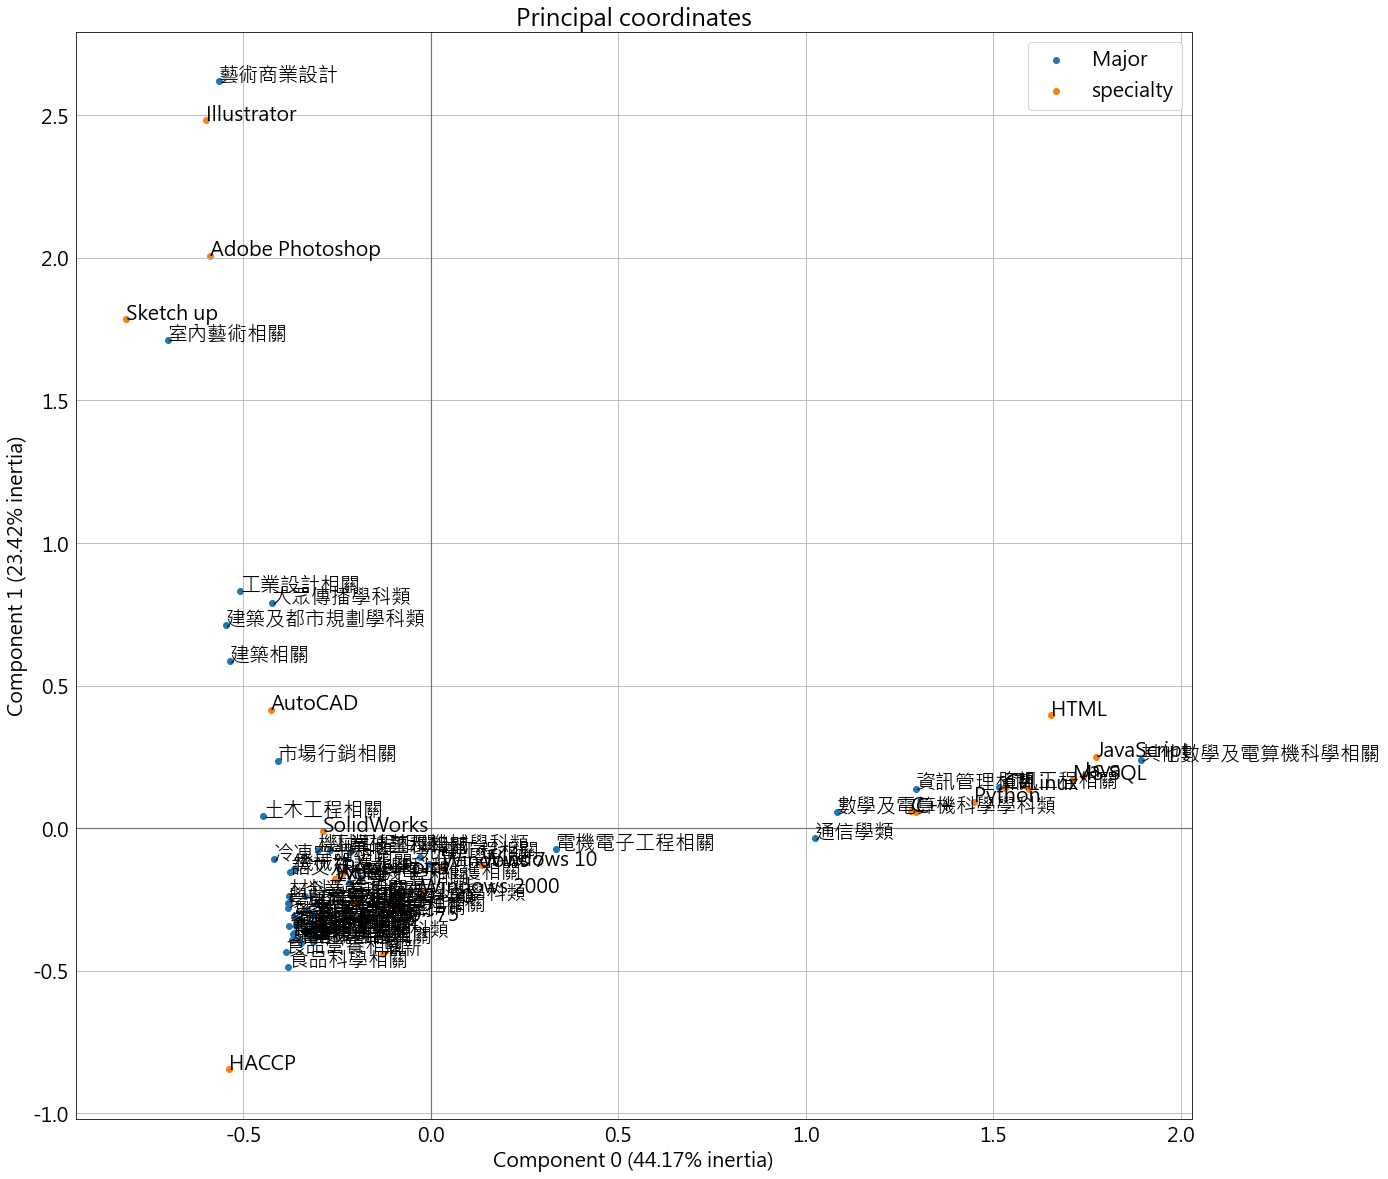

In [67]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

ax = ca.plot_coordinates(
     X=X,
     ax=None,
     figsize=(20, 20),
     x_component=0,
     y_component=1,
     show_row_labels=True,
     show_col_labels=True )
ax

## 這幾年大數據很熱門，也有很多公司在做數位轉型，社會學系的學生在這個方面有哪些挑戰與機會?
- 撈出資料科學、數據分析的職缺，剖析差異
- 數位轉型的工作有分成行銷管理、商業分析、資料科學、資料工程...
- 社會學可以試試看商業分析

In [149]:
df.head()

,index,jobName,custName,major,specialty,skill,jobDetail,jobCategory,nsalaryMin
0,0,作業員,總信食品有限公司,[],[],[],旺季需配合加班需能配合加班，享勞健團保食品餐飲相關科系為佳,"[{'code': '2010001002', 'description': '作業員／包裝...",25-30k
1,1,汐止分院護理人員(內外科病房.加護病房.門診.安寧病房.護理之家),國泰醫療財團法人國泰綜合醫院,[護理助產相關],[],[],"病人護理照護。1.護理師月薪41,000~43,000元起2.包夜班費：4,000~5,00...","[{'code': '2015001004', 'description': '護理師及護士...",40k+
2,2,印刷見習技師,康揚特殊美術印刷股份有限公司,[],[],[],1.在印刷機上安裝及調整印版。2.調整壓力。3.於印刷機著墨，裝上紙張，並根據紙張的尺寸調整...,"[{'code': '2010001012', 'description': '印前製作／印...",25-30k
3,3,證券營業員(南科分公司),國票綜合證券股份有限公司,[],[],[],1.對證券現貨、期貨及新金融商品投資具興趣。 2.自認可吃苦耐勞、勇於負責者。 3.個性外向...,"[{'code': '2003002005', 'description': '金融營業員'...",25k-
4,4,美編設計(需具經驗),益盛多媒體印刷有限公司,[],"[{'code': '12001003001', 'description': 'A+'},...",[],美編設計人員:需熟Adobe InDesign、Illustrator、Photoshop ...,"[{'code': '2013001005', 'description': '平面設計／美...",40k+


In [150]:
df['jobName'].apply(lambda x: bool(re.search('資料科學', x)))

0         False
1         False
2         False
3         False
4         False
          ...  
195635    False
195636    False
195637    False
195638    False
195639    False
Name: jobName, Length: 195631, dtype: bool

In [157]:
np.select(condlist = [df['jobName'].apply(lambda x: bool(re.search('資料科學|數據分析|資料分析', x))),
                      df['jobDetail'].apply(lambda x: bool(re.search('資料科學|數據分析|資料分析', x)))],
          choicelist = [True,True],
          default=False)

array([False, False, False, ..., False, False, False])

,index,jobName,custName,major,specialty,skill,jobDetail,jobCategory,nsalaryMin
46,48,工地測量人員(無經驗可),政皓工程有限公司,[],[],[],1.大地工程安全監測、監測儀器安裝量測、數據分析、自動化監測系統。2.儀器送檢並追蹤進度，確...,"[{'code': '2012003005', 'description': '量測／儀校人...",30-35k
304,307,網路系統工程師 (一年以上contractor)_台北/桃園,台灣恩悌悌系統股份有限公司,[資訊工程相關],"[{'code': '12001007014', 'description': 'Check...",[],1. 1.\t網路設備及數據線路狀態檢視2. 網路架構資料製作及更新3. 設備設定操作手冊製...,"[{'code': '2007002005', 'description': '網路管理工程...",35-40k
391,395,資訊專員,裕新汽車股份有限公司,"[商業及管理學科類, 數學及電算機科學學科類]","[{'code': '12001003005', 'description': 'ASP'}...","[{'code': '11009005001', 'description': '軟體程式設...",1、公司內部程式修改2、使用帳號管理3、使用者問題協助4、MIS機房及資訊設備管理5、 公司...,"[{'code': '2007001004', 'description': '軟體設計工程...",40k+
410,414,國外業務助理/國外業務 (儲備幹部),泰瑋電子有限公司,[商業及管理學科類],[],[],1.負責國外業務接洽，完成銷售業務之行政後勤工作，訂單之處理及客戶端之溝通事宜2. 各項業務...,"[{'code': '2005003013', 'description': '業務助理'}...",35-40k
453,458,FA助理工程師,銘鈺精密工業股份有限公司,[],"[{'code': '12001008003', 'description': 'Excel...",[],1.具工程識圖能力/GD&T 計算能力/基本量具使用2.Mitutoyo cmm/Nikon...,"[{'code': '2009003002', 'description': '品管／品保工...",30-35k
...,...,...,...,...,...,...,...,...,...
195046,200133,軟體工程師,啟德電子股份有限公司,"[資訊工程相關, 資訊管理相關]",[],[],撰寫C#工具程式，網路程式，資料分析。,"[{'code': '2007001004', 'description': '軟體設計工程...",25-30k
195113,200200,行銷企劃人員,南昌行股份有限公司,[],"[{'code': '12001008003', 'description': 'Excel...",[],1. 消費性食品之行銷、新產品開發、規劃及執行2. 年度產品行銷策略規劃及執行、新產品評估開...,"[{'code': '2004001005', 'description': '行銷企劃人員...",30-35k
195180,200268,心測中心-(會考)英語科研究員,國立臺灣師範大學_心理與教育測驗研究發展中心,[英美語文相關],"[{'code': '12001008003', 'description': 'Excel...","[{'code': '11017009010', 'description': '進行教學成...",國中英語科領域課程統整、評量工具（試題）設計 學科資料分析研究１、大學與研究所皆為英語相關科...,"[{'code': '2016001013', 'description': '研究助理'}...",35-40k
195322,200410,水利工程師/水文地質工程師,國立雲林科技大學_水土資源及防災科技研究中心,"[自然科學學科類, 工程學科類]",[],[],1.\t獨立執行環工、水資源、水文地質等專案計畫及進行進度掌控。2.\t進行業主或協力廠商溝...,"[{'code': '2012001006', 'description': '水利工程師'...",35-40k


# 提交報告
- 根據前面的發現我們就可以跟傑華老師分享我們的分析結果囉~~
- 第1點的分析可以幫我們了解勞動市場上是怎麼看社會學的學生
> 市場上對於社會學系畢業的學生的期待還是社工，如果要扭轉這種形象建議多舉辦結合社會學與大數據分析的講座並宣傳，例如找學長(誤)
- 第2點的分析我們可以看學跟用之間有沒有落差，反省課綱
> 
- 第3點的分析...
> 

# 總結
- 能完成一件事從來不是單純看能力有多強，而是你有多在乎(Tony, 2020)
- 要有獨立完成分析專案的能力，但你不能只會分析
- - 小提醒：可以多從udemy, udacity取得證書

# 貼心叮嚀
- 不是每位老師都接受量化研究，所以在做期末報告的時候要探聽一下老師的口味

# Todo
- spaCy 如何新增新詞